In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pathlib
import cv2
from keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

2026-01-08 19:53:28.169436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767902008.598181      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767902008.731846      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
DATA_DIR = os.path.join("/kaggle/input/containers-damage/containers")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VALID_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR = os.path.join(DATA_DIR, "test")

In [3]:
def show_image(img_path:str):
    # Görüntüyü okuma
    img = mpimg.imread(img_path)

    # Boyut bilgisi
    print("Görüntü boyutu:", img.shape)

    # Gösterme
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Görüntü boyutu: (640, 640, 3)


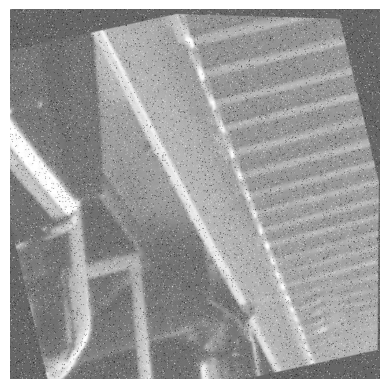

In [4]:
show_image(os.path.join(VALID_DIR, "damaged", "ContainerDamage_1001.jpg"))

In [5]:
def check_same_size(dir_name:str, class_name:str, DATA_DIR=DATA_DIR):
    root = os.path.join(
        DATA_DIR,
        dir_name,
        class_name)

    sizes = set()

    for file in os.listdir(root):
        if file.lower().endswith(".jpg"):
            img_path = os.path.join(root, file)
            with Image.open(img_path) as img:
                sizes.add(img.size)   # (width, height)

    print("Toplam farklı boyut sayısı:", len(sizes))
    print("Farklı boyutlar:", sizes)

In [6]:
print(*"Train - Damaged Image Size")
check_same_size("train", "damaged")
print(*"Train - Not Damaged Image Size")
check_same_size("train", "not_damaged")
print(*"Test - Damaged Image Size")
check_same_size("test", "damaged")
print(*"Test - Not Damaged Image Size")
check_same_size("test", "not_damaged")
print(*"Valid - Damaged Image Size")
check_same_size("valid", "damaged")
print(*"Valid - Not Damaged Image Size")
check_same_size("valid", "not_damaged")

T r a i n   -   D a m a g e d   I m a g e   S i z e
Toplam farklı boyut sayısı: 1
Farklı boyutlar: {(640, 640)}
T r a i n   -   N o t   D a m a g e d   I m a g e   S i z e
Toplam farklı boyut sayısı: 2
Farklı boyutlar: {(416, 416), (640, 640)}
T e s t   -   D a m a g e d   I m a g e   S i z e
Toplam farklı boyut sayısı: 1
Farklı boyutlar: {(640, 640)}
T e s t   -   N o t   D a m a g e d   I m a g e   S i z e
Toplam farklı boyut sayısı: 2
Farklı boyutlar: {(416, 416), (640, 640)}
V a l i d   -   D a m a g e d   I m a g e   S i z e
Toplam farklı boyut sayısı: 1
Farklı boyutlar: {(640, 640)}
V a l i d   -   N o t   D a m a g e d   I m a g e   S i z e
Toplam farklı boyut sayısı: 2
Farklı boyutlar: {(416, 416), (640, 640)}


In [7]:
#Global initialization of some imp variables
Image_Size = 256
Batch_Size = 32
Channels = 3
Epochs = 100

mean = 0.5        # Örnek değer, datasetin ortalamasıyla değiştirilmeli
std = 0.25        # Örnek değer, datasetin std ile değiştirilmeli

# Preprocessing

In [8]:
def preprocess_image(img):
    # Normalize
    img = img / 255.0
    img = tf.cast(img, tf.float32)
    img = (img - mean) / std

    # ---- TensorFlow Gaussian Blur ----
    def gaussian_kernel(size=3, sigma=1.0):
        ax = tf.range(-size // 2 + 1, size // 2 + 1, dtype=tf.float32)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
        kernel /= tf.reduce_sum(kernel)
        kernel = kernel[:, :, tf.newaxis, tf.newaxis]
        kernel = tf.repeat(kernel, repeats=3, axis=2)
        return kernel

    kernel = gaussian_kernel(3, 1.0)

    # Depthwise conv — batch boyutu zaten var, extra eklemeye gerek yok
    img = tf.nn.depthwise_conv2d(
        img,            # artık img shape: [batch, H, W, C]
        kernel,
        strides=[1, 1, 1, 1],
        padding="SAME"
    )

    return img

In [9]:
def load_dataset(directory, batch_size=32, shuffle=True):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=(Image_Size, Image_Size),   # tekrar aktifleştirildi
        batch_size=batch_size,
        shuffle=shuffle
    )

    def apply_preprocess(img, label):
        img = preprocess_image(img)
        return img, label

    dataset = dataset.map(apply_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [10]:
train_ds = load_dataset(TRAIN_DIR, batch_size=32, shuffle=True)
valid_ds = load_dataset(VALID_DIR, batch_size=32, shuffle=False)
test_ds  = load_dataset(TEST_DIR, batch_size=32, shuffle=False)

Found 4415 files belonging to 2 classes.


I0000 00:00:1767902085.725574      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767902085.726187      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 527 files belonging to 2 classes.
Found 452 files belonging to 2 classes.


# Visualization Some Kernels as Matrix

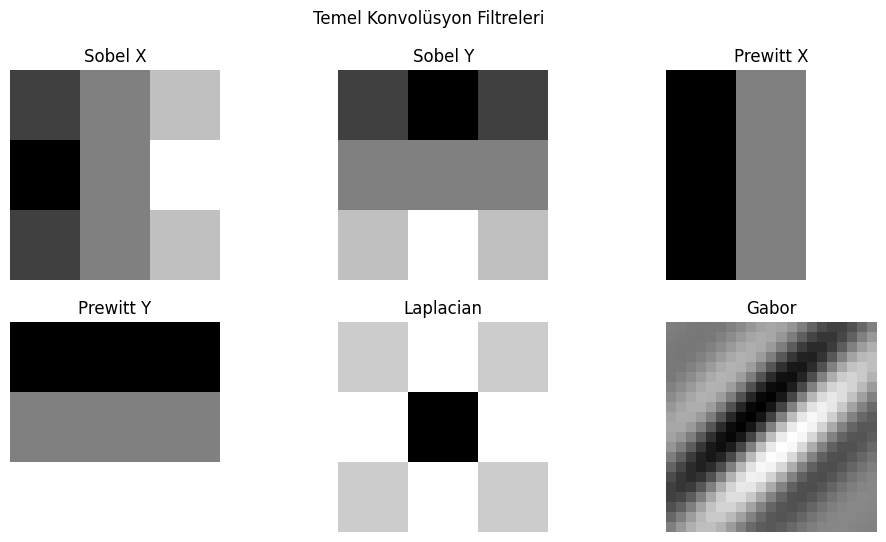

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Sobel X ve Y
sobel_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
sobel_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

# Prewitt X ve Y
prewitt_x = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
prewitt_y = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])

# Laplacian
laplacian = np.array([[0,1,0],[1,-4,1],[0,1,0]])

# Gabor kernel örneği
gabor_kernel = cv2.getGaborKernel((21,21), sigma=5, theta=np.pi/4, lambd=10, gamma=0.5)

# Görselleştirme
kernels = {'Sobel X':sobel_x, 'Sobel Y':sobel_y,
           'Prewitt X':prewitt_x, 'Prewitt Y':prewitt_y,
           'Laplacian':laplacian, 'Gabor':gabor_kernel}

plt.figure(figsize=(12,6))
for i, (name, kernel) in enumerate(kernels.items()):
    plt.subplot(2,3,i+1)
    plt.imshow(kernel, cmap='gray')
    plt.title(name)
    plt.axis('off')
plt.suptitle("Temel Konvolüsyon Filtreleri")
plt.show()


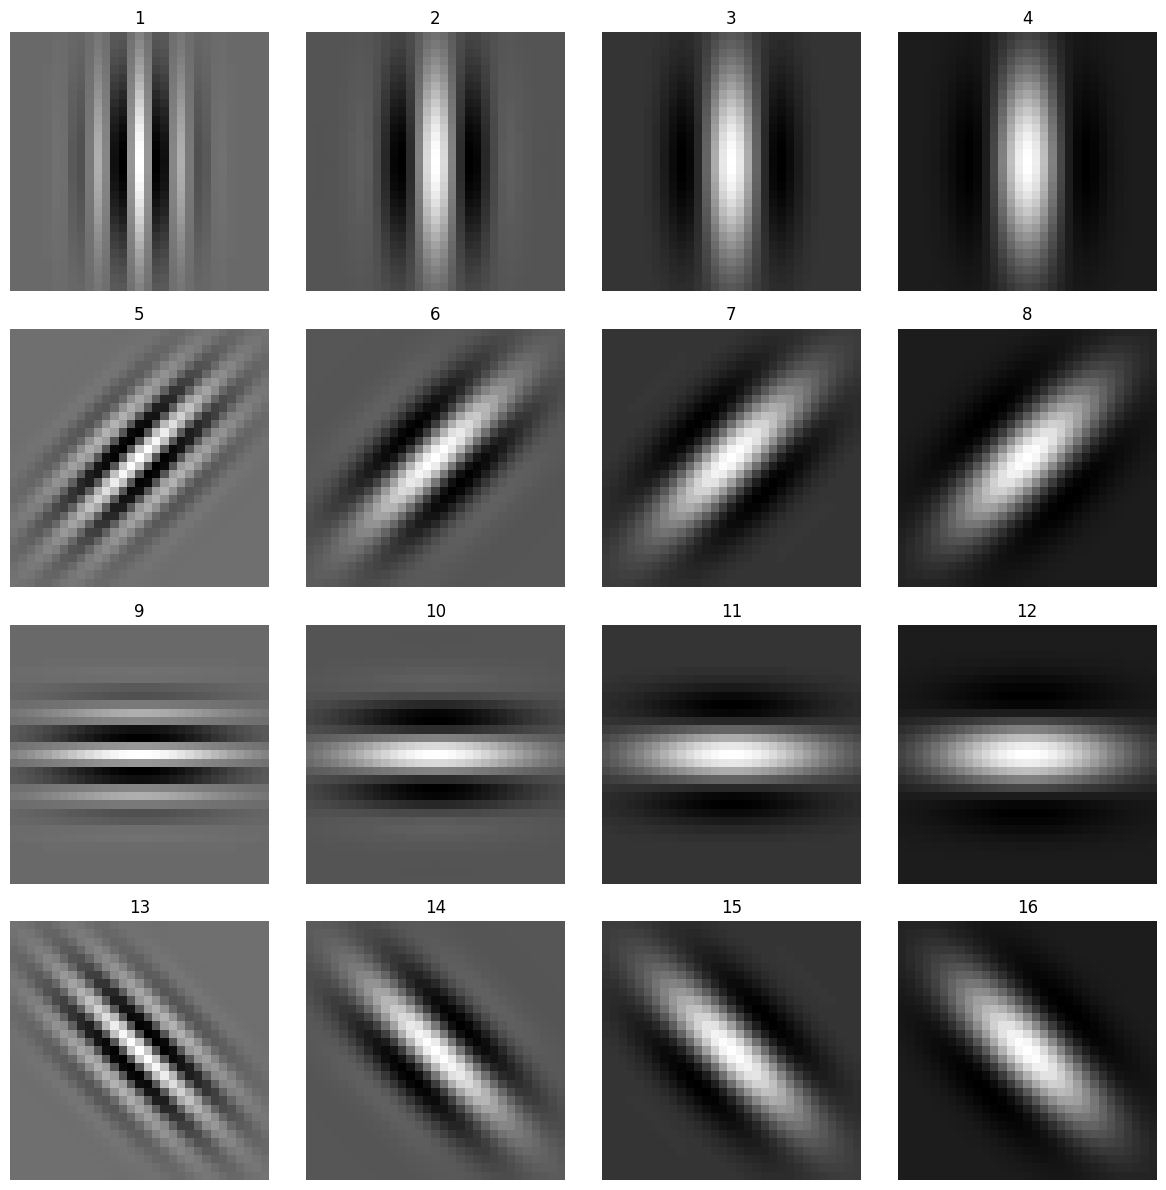

In [12]:
def plot_gabor_kernels(ksize=31, sigma=4.0, gamma=0.5, psi=0):
    """
    16 adet Gabor filtresini (kernel) 4x4 grid şeklinde plot eder.
    """
    thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    lambdas = [5, 10, 15, 20]

    kernels = []

    for theta in thetas:
        for lam in lambdas:
            kernel = cv2.getGaborKernel(
                (ksize, ksize),
                sigma,
                theta,
                lam,
                gamma,
                psi,
                ktype=cv2.CV_32F
            )
            kernels.append(kernel)

    plt.figure(figsize=(12, 12))

    for i, k in enumerate(kernels):
        plt.subplot(4, 4, i + 1)
        plt.imshow(k, cmap='gray')
        plt.title(f"{i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
plot_gabor_kernels()

In [13]:
class Filters:
    def __init__(self, img_path=None):
        self.img_path = img_path
        self.lap_norm = None
        self.sobelX_output_norm = None
        self.prewittX_filter_output_norm = None
        self.sobelY_output_norm = None
        self.prewittY_filter_output_norm = None
        self.canny_output_norm = None
        self.gabor_outputs = None
        self.median_blur_output_norm = None # Added Median Blur output
        self.filter_done = False
        self.gabor_filter_done = False
        self.fft_suppressed=None
        self.fft_residual=None
        self.fft_residual_output_norm=None
        self.fft_suppressed_local=None
        self.fft_residual_local=None
        self.fft_residual_local_output_norm=None
        self.residual_sobel_mag = None
        self.residual_laplacian = None
        self.residual_sobel_mag_masked = None
        self.residual_laplacian_masked = None
        self.fft_residual_local_output_norm_with_harmonics=None
        self.residual_sobel_mag_with_harmonics=None
        self.residual_laplacian_with_harmonics=None
        self.residual_sobel_mag_with_harmonics_masked = None
        self.residual_laplacian_with_harmonics_masked = None

    def laplacian_filter(self):
        image = cv2.imread(self.img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        laplacian_output_img = cv2.Laplacian(image, cv2.CV_64F)
        return laplacian_output_img

    def sobelX_filter(self):
        image = cv2.imread(self.img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sobelX_output_img = cv2.Sobel(image, cv2.CV_64F, 1, 0)
        return sobelX_output_img

    def sobelY_filter(self):
        image = cv2.imread(self.img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sobelY_output_img = cv2.Sobel(image, cv2.CV_64F, 0, 1)
        return sobelY_output_img

    def prewittX_filter(self):
        image = cv2.imread(self.img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Prewitt X yönü çekirdeği
        kernelX = np.array([[ -1, 0, 1],
                            [ -1, 0, 1],
                            [ -1, 0, 1]])

        prewittX_output_img = cv2.filter2D(image, cv2.CV_64F, kernelX)
        return prewittX_output_img

    def prewittY_filter(self):
        image = cv2.imread(self.img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Prewitt Y yönü çekirdeği
        kernelY = np.array([[ -1, -1, -1],
                            [  0,  0,  0],
                            [  1,  1,  1]])

        prewittY_output_img = cv2.filter2D(image, cv2.CV_64F, kernelY)
        return prewittY_output_img

    def canny_filter(self):
        sigma = 0.33
        # Görüntüyü yükle ve griye çevir
        image = cv2.imread(self.img_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Gaussian blur uygula (gürültüyü azaltmak için)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)  # 5x5 kernel, sigma=0
        # Median değer üzerinden threshold belirleme (opsiyonel, şimdilik sabit)
        median_val = np.median(blur)
        lower_thresh = 35  # int(max(0, (1.0 - sigma) * median_val))
        upper_thresh = 100 # int(min(255, (1.0 + sigma) * median_val))
        # Canny edge detection
        canny_output_img = cv2.Canny(blur, lower_thresh, upper_thresh)
        return canny_output_img
        
    # Median removes salt-and-pepper noise while keeping edges sharp.
    def median_blur_filter(self, ksize=5):
        image = cv2.imread(self.img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        median_blur_output_img = cv2.medianBlur(image, ksize)
        return median_blur_output_img

    # Bilateral reduces noise in flat regions while preserving edge positions.
    def bilateral_filter(self, d=9, sigmaColor=75, sigmaSpace=75):
        image = cv2.imread(self.img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Apply bilateral filter
        # d: Diameter of each pixel neighborhood.
        # sigmaColor: Filter sigma in the color space. A larger value of the parameter means that farther colors within the pixel neighborhood (see sigmaSpace) will be mixed together, resulting in larger areas of semi-equal color.
        # sigmaSpace: Filter sigma in the coordinate space. A larger value of the parameter means that farther pixels will influence each other as long as their colors are close enough (see sigmaColor). When d>0, it specifies the neighborhood size regardless of sigmaSpace. Otherwise, d is proportional to sigmaSpace.
        bilateral_output_img = cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)
        return bilateral_output_img
    ############################################

    
    def apply_gabor_filters(self):
        """
        OpenCV kullanarak 16 Gabor filtresi uygular ve çıktıları liste halinde döndürür.

        Parametre:
            img : np.ndarray
                Gri tonlamalı giriş görüntüsü.

        Returns:
            gabor_outputs : list of np.ndarray
                Her bir Gabor filtresinin uygulanmış sonucu.
        """
        # Gabor filtre parametreleri
        ksize = 31           # kernel boyutu
        sigma = 4.0          # Gauss sigma
        lambd = 10.0         # dalga boyu
        gamma = 0.5          # aspect ratio
        psi = 0              # faz ofseti

        gabor_outputs = []
        img = cv2.imread(self.img_path, cv2.IMREAD_GRAYSCALE)

        # 4 farklı yön (0, 45, 90, 135 derece) ve 4 farklı frekans için toplam 16 filtre
        thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        lambdas = [5, 10, 15, 20]

        for theta in thetas:
            for lam in lambdas:
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lam, gamma, psi, ktype=cv2.CV_32F)
                filtered_img = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                gabor_outputs.append(filtered_img)
        self.gabor_filter_done = True
        self.gabor_outputs = gabor_outputs.copy()

    def plot_gabor_filter_results(self):
        # gabor_output, apply_gabor_filters() ile elde edilen liste
        if(self.gabor_filter_done == False):
            print("gabor_filter_done == False")
            self.apply_gabor_filters()

        fig, axes = plt.subplots(4, 4, figsize=(16, 16))
        axes = axes.ravel()  # 2D array'i 1D olarak düzleştir

        for idx, i in enumerate(self.gabor_outputs):
            # Normalize et
            gabor_output_norm = (i - i.min()) / (i.max() - i.min())
            axes[idx].imshow(gabor_output_norm, cmap='gray')
            axes[idx].axis('off')  # eksenleri kapat
            axes[idx].set_title(f'Filter {idx+1}')
        plt.tight_layout()
        plt.show()

    # Sinusoidal FFT Filter #
    def sinusoidal_notch_filter(self, k=2, notch_radius=10, center_exclusion=40):
        """
        Removes repeated (corrugated) pattern using FFT peak detection + notch filtering.
    
        Parameters
        ----------
        img : np.ndarray
            Input image (RGB or grayscale)
        k : int
            Number of dominant frequency peaks to remove
        notch_radius : int
            Radius of notch around each peak
        center_exclusion : int
            Ignore low frequencies around FFT center
    
        Returns
        -------
        suppressed : np.ndarray
            Image with periodic pattern suppressed
        residual : np.ndarray
            |original - suppressed| → defect-like structures
        """
        img = cv2.imread(self.img_path)
        if img.ndim == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img.copy()
    
        gray = gray.astype(np.float32)
    
        # --- 2. FFT ---
        F = np.fft.fft2(gray)
        Fshift = np.fft.fftshift(F)
        magnitude = np.log1p(np.abs(Fshift))
    
        h, w = magnitude.shape
        cy, cx = h // 2, w // 2
    
        # --- 3. Find dominant peaks (periodic pattern) ---
        mag_copy = magnitude.copy()
        mag_copy[cy-center_exclusion:cy+center_exclusion,
                 cx-center_exclusion:cx+center_exclusion] = 0
    
        peaks = []
        for _ in range(k):
            y, x = np.unravel_index(np.argmax(mag_copy), mag_copy.shape)
            peaks.append((y, x))
            mag_copy[y-notch_radius:y+notch_radius,
                     x-notch_radius:x+notch_radius] = 0
    
        # --- 4. Build notch mask ---
        mask = np.ones((h, w), dtype=np.float32)
    
        for (y, x) in peaks:
            cv2.circle(mask, (x, y), notch_radius, 0, -1)
            sy, sx = 2*cy - y, 2*cx - x  # symmetric peak
            if 0 <= sy < h and 0 <= sx < w:
                cv2.circle(mask, (sx, sy), notch_radius, 0, -1)
    
        # --- 5. Apply notch filter ---
        F_filtered = Fshift * mask
        F_ishift = np.fft.ifftshift(F_filtered)
        suppressed = np.fft.ifft2(F_ishift).real
    
        # --- 6. Residual (defects) ---
        residual = np.abs(gray - suppressed)

        # plt.imshow(residual, cmap='gray')
    
        return suppressed, residual



    
    # Local Sinusoidal FFT Filter #

    def sinusoidal_notch_filter_local(self,
                                      strip_width=48,
                                      overlap=24,
                                      notch_halfwidth=3,
                                      exclude_low_bins=2):
        """
        Local (adaptive) periodicity suppression for corrugated containers.
        Works better than global FFT when perspective causes the period to vary across the image.
    
        Idea:
          - Split image into overlapping vertical strips
          - For each strip, estimate dominant corrugation frequency along X (horizontal) using 1D FFT
          - Apply a 1D notch (band-stop) to every row in that strip
          - Overlap-add the filtered strips back
    
        Parameters
        ----------
        img : np.ndarray
            Input image (BGR/RGB or grayscale)
        strip_width : int
            Width of vertical strip (pixels). Typical: 64..160
        overlap : int
            Overlap between strips (pixels). Typical: strip_width//2
        notch_halfwidth : int
            Half-width of notch around the peak bin (in FFT bins). Typical: 1..5
        exclude_low_bins : int
            Ignore very low frequency bins (including DC). Typical: 2..6
    
        Returns
        -------
        suppressed : np.ndarray (float32)
            Image with corrugation (repeated ribs) suppressed (locally)
        residual : np.ndarray (float32)
            abs(gray - suppressed): defect-like components emphasized
        """
        # --- 1) grayscale float32 ---
        img = cv2.imread(self.img_path)
        if img.ndim == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
        else:
            gray = img.astype(np.float32)
    
        H, W = gray.shape
        sw = int(strip_width)
        ov = int(overlap)
        step = max(1, sw - ov)
    
        # Accumulators for overlap-add
        out_acc = np.zeros((H, W), dtype=np.float32)
        w_acc = np.zeros((H, W), dtype=np.float32)
    
        # --- helper: create 1D notch mask for length N ---
        def make_notch_mask(N, peak_idx, halfw):
            mask = np.ones(N, dtype=np.float32)
    
            # notch around +peak
            a = max(0, peak_idx - halfw)
            b = min(N, peak_idx + halfw + 1)
            mask[a:b] = 0.0
    
            # notch around symmetric -peak
            sym = (N - peak_idx) % N
            a2 = max(0, sym - halfw)
            b2 = min(N, sym + halfw + 1)
            mask[a2:b2] = 0.0
    
            # keep DC (optional): here we keep it; if you want remove DC, set mask[0]=0
            return mask
    
        # --- 2) process strips ---
        for x0 in range(0, W, step):
            x1 = min(W, x0 + sw)
            strip = gray[:, x0:x1]  # H x sw'
    
            # If last strip is smaller, pad to sw for FFT stability
            cur_w = strip.shape[1]
            if cur_w < sw:
                pad = sw - cur_w
                strip_padded = np.pad(strip, ((0, 0), (0, pad)), mode="edge")
            else:
                strip_padded = strip
    
            N = strip_padded.shape[1]
    
            # --- 2a) estimate dominant frequency bin (corrugation) ---
            # Use average magnitude spectrum across rows for robustness
            F = np.fft.fft(strip_padded, axis=1)  # FFT along X
            mag = np.mean(np.abs(F), axis=0)      # average over rows
    
            # Ignore DC and low bins
            mag2 = mag.copy()
            mag2[:exclude_low_bins] = 0.0
            # also ignore the mirrored very-low end (optional)
            mag2[-exclude_low_bins:] = 0.0
    
            peak_idx = int(np.argmax(mag2))
            # If no meaningful peak, just pass-through
            if mag2[peak_idx] <= 0:
                strip_filt = strip_padded.copy()
            else:
                mask_1d = make_notch_mask(N, peak_idx, notch_halfwidth)
                strip_filt = np.fft.ifft(F * mask_1d[None, :], axis=1).real.astype(np.float32)
    
            # Remove padding (if any)
            strip_filt = strip_filt[:, :cur_w]
    
            # --- 2b) overlap-add back ---
            out_acc[:, x0:x1] += strip_filt
            w_acc[:, x0:x1] += 1.0
    
            if x1 >= W:
                break
    
        # --- 3) normalize overlap-add ---
        suppressed = out_acc / np.maximum(w_acc, 1e-6)
    
        # --- 4) residual for defects ---
        residual = np.abs(gray - suppressed)
    
        return suppressed.astype(np.float32), residual.astype(np.float32)


    # Improve and Develop Local Sinusoidal FFT Filter with Harmonics #

    def sinusoidal_notch_filter_local_with_harmonics(self,
                                  strip_width=48,
                                  overlap=24,
                                  notch_halfwidth=3,
                                  exclude_low_bins=2,
                                  num_harmonics=2):

        img = cv2.imread(self.img_path)
        if img.ndim == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
        else:
            gray = img.astype(np.float32)
    
        H, W = gray.shape
        sw = int(strip_width)
        ov = int(overlap)
        step = max(1, sw - ov)
    
        out_acc = np.zeros((H, W), dtype=np.float32)
        w_acc = np.zeros((H, W), dtype=np.float32)
    
        def notch_bins(mask, idx, halfw):
            N = mask.shape[0]
            a = max(0, idx - halfw); b = min(N, idx + halfw + 1)
            mask[a:b] = 0.0
            sym = (N - idx) % N
            a2 = max(0, sym - halfw); b2 = min(N, sym + halfw + 1)
            mask[a2:b2] = 0.0
    
        for x0 in range(0, W, step):
            x1 = min(W, x0 + sw)
            strip = gray[:, x0:x1]
            cur_w = strip.shape[1]
    
            if cur_w < sw:
                strip_padded = np.pad(strip, ((0, 0), (0, sw - cur_w)), mode="edge")
            else:
                strip_padded = strip
    
            N = strip_padded.shape[1]
    
            F = np.fft.fft(strip_padded, axis=1)
            mag = np.mean(np.abs(F), axis=0)
    
            mag2 = mag.copy()
            mag2[:exclude_low_bins] = 0
            mag2[-exclude_low_bins:] = 0
    
            peak_idx = int(np.argmax(mag2))
    
            # create 1D mask and notch peak + harmonics
            mask = np.ones(N, dtype=np.float32)
            if mag2[peak_idx] > 0:
                for h in range(1, num_harmonics + 1):
                    idx = h * peak_idx
                    if 1 <= idx < N//2:  # stay meaningful
                        notch_bins(mask, idx, notch_halfwidth)
    
            strip_filt = np.fft.ifft(F * mask[None, :], axis=1).real.astype(np.float32)
            strip_filt = strip_filt[:, :cur_w]
    
            out_acc[:, x0:x1] += strip_filt
            w_acc[:, x0:x1] += 1.0
    
            if x1 >= W:
                break
    
        suppressed = out_acc / np.maximum(w_acc, 1e-6)
        residual = np.abs(gray - suppressed)
        return suppressed, residual

    # Otsu Thresholding #

    def residual_to_mask(self, residual, p_low=2, p_high=98, thr_method="otsu"):
        r = residual.astype(np.float32)
        lo, hi = np.percentile(r, [p_low, p_high])
        r = np.clip(r, lo, hi)
        r = (r - lo) / (hi - lo + 1e-6)
        r8 = (r * 255).astype(np.uint8)
    
        if thr_method == "otsu":
            _, mask = cv2.threshold(r8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        else:
            # adaptive for heavy illumination variation
            mask = cv2.adaptiveThreshold(
                r8, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY, 31, 2
            )
        return mask

    # Remove the lines #

    def remove_line_like_components(self, mask, min_area=40, max_aspect=8.0):
        # mask must be 0/255 uint8
        num, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
        out = np.zeros_like(mask)
    
        for i in range(1, num):  # skip background
            x, y, w, h, area = stats[i]
            if area < min_area:
                continue
    
            aspect = max(w, h) / (min(w, h) + 1e-6)


        
            # If it is extremely long & thin -> likely rib remnant -> skip it
            if aspect > max_aspect:
                continue
    
            out[labels == i] = 255
    
        return out

    # Detecting the lines and substract them from the image #   

    def postprocess_defects(self, residual):
        # 1) threshold
        mask = self.residual_to_mask(residual, thr_method="otsu")

        for _ in range(4):

            k_vert = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
            lines = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k_vert)
            
            # Subtract detected lines
            mask= cv2.subtract(mask, lines)
    
        # 4) remove line-like connected components (final clean)
        mask = self.remove_line_like_components(mask, min_area=60, max_aspect=9.0)
    
        return mask


    def run_filters(self):
        laplacian_output = self.laplacian_filter()
        lap_norm = (laplacian_output - laplacian_output.min()) / (laplacian_output.max() - laplacian_output.min())
    
        sobelX_output = self.sobelX_filter()
        sobelX_output_norm = (sobelX_output - sobelX_output.min()) / (sobelX_output.max() - sobelX_output.min())
    
        prewittX_filter_output = self.prewittX_filter()
        prewittX_filter_output_norm = (prewittX_filter_output - prewittX_filter_output.min()) / (prewittX_filter_output.max() - prewittX_filter_output.min())
    
        sobelY_output = self.sobelY_filter()
        sobelY_output_norm = (sobelY_output - sobelY_output.min()) / (sobelY_output.max() - sobelY_output.min())
    
        prewittY_filter_output = self.prewittY_filter()
        prewittY_filter_output_norm = (prewittY_filter_output - prewittY_filter_output.min()) / (prewittY_filter_output.max() - prewittY_filter_output.min())
    
        canny_output = self.canny_filter()
        canny_output_norm = (canny_output - canny_output.min()) / (canny_output.max() - canny_output.min())
    
        median_blur_output = self.median_blur_filter()
        median_blur_output_norm = (median_blur_output - median_blur_output.min()) / (median_blur_output.max() - median_blur_output.min())
        bilateral_output = self.bilateral_filter()
        bilateral_filter_output_norm = (bilateral_output - bilateral_output.min()) / (bilateral_output.max() - bilateral_output.min())
        ########
        
        self.lap_norm = lap_norm
        self.sobelX_output_norm = sobelX_output_norm
        self.prewittX_filter_output_norm = prewittX_filter_output_norm
        self.sobelY_output_norm = sobelY_output_norm
        self.prewittY_filter_output_norm = prewittY_filter_output_norm
        self.canny_output_norm = canny_output_norm
    
        self.median_blur_output_norm = median_blur_output_norm # Stored normalized median blur output
        self.bilateral_filter_output_norm = bilateral_filter_output_norm # Stored normalized bilateral filter output
        ########


        def _norm01(x):
            mn, mx = x.min(), x.max()
            if (mx - mn) > 1e-6:
                return (x - mn) / (mx - mn)
            return x

        # SINUSOIDAL FFT FILTER#

        # Remove repeated (corrugated) pattern using FFT notch filtering
        fft_suppressed, fft_residual = self.sinusoidal_notch_filter()

        if fft_residual is not None and fft_residual.max() != fft_residual.min():
            fft_residual_output_norm = (fft_residual - fft_residual.min()) / (fft_residual.max() - fft_residual.min())
        else:
            fft_residual_output_norm = fft_residual

        self.fft_residual_output_norm=fft_residual_output_norm  

        # LOCAL SINUSOIDAL FFT FILTER#

        fft_suppressed_local, fft_residual_local = self.sinusoidal_notch_filter_local()
        fft_suppressed_local_with_harmonics, fft_residual_local_with_harmonics = self.sinusoidal_notch_filter_local_with_harmonics()

        self.fft_residual_local_output_norm = _norm01(fft_residual_local)

        self.fft_residual_local_output_norm_with_harmonics = _norm01(fft_residual_local_with_harmonics)

        # LOCAL SINUSOIDAL FFT FILTER + SOBEL + LAPLACIAN #

        def residual_sobel_laplacian(local_output_norm):
            residual_sobel_x = cv2.Sobel(local_output_norm, cv2.CV_32F, 1, 0, ksize=3)
            residual_sobel_y = cv2.Sobel(local_output_norm, cv2.CV_32F, 0, 1, ksize=3)
            residual_sobel_mag = cv2.magnitude(residual_sobel_x, residual_sobel_y)
    
            residual_laplacian = cv2.Laplacian(local_output_norm, cv2.CV_32F)
    
            residual_sobel_mag = _norm01(residual_sobel_mag)
            residual_laplacian = _norm01(residual_laplacian)

            return residual_sobel_mag, residual_laplacian

        self.residual_sobel_mag, self.residual_laplacian=residual_sobel_laplacian(self.fft_residual_local_output_norm)
        self.residual_sobel_mag_with_harmonics, self.residual_laplacian_with_harmonics=residual_sobel_laplacian(self.fft_residual_local_output_norm_with_harmonics)

        
        # LOCAL SINUSOIDAL FFT FILTER + SOBEL + LAPLACIAN by Applying Thresholding and Mask Operations #

        self.residual_sobel_mag_masked = self.postprocess_defects(self.residual_sobel_mag)
        self.residual_laplacian_masked = self.postprocess_defects(self.residual_laplacian)
        self.residual_sobel_mag_with_harmonics_masked = self.postprocess_defects(self.residual_sobel_mag_with_harmonics)
        self.residual_laplacian_with_harmonics_masked = self.postprocess_defects(self.residual_laplacian_with_harmonics)
        
        self.filter_done = True

    def plot_filters(self):
        outputs = []
        if(self.filter_done  == False):
            self.run_filters()
        outputs = [self.lap_norm, self.sobelX_output_norm, self.prewittX_filter_output_norm, self.sobelY_output_norm, self.prewittY_filter_output_norm, self.canny_output_norm, self.median_blur_output_norm, self.bilateral_filter_output_norm,self.fft_residual_output_norm, self.fft_residual_local_output_norm, self.residual_sobel_mag, self.residual_laplacian, self.fft_residual_local_output_norm_with_harmonics, self.residual_sobel_mag_with_harmonics, self.residual_laplacian_with_harmonics, self.residual_sobel_mag_masked, self.residual_laplacian_masked, self.residual_sobel_mag_with_harmonics_masked, self.residual_laplacian_with_harmonics_masked] # Added median blur to outputs
    
        filters = ['Laplacian', 'Sobel X', 'Prewitt X', 'Sobel Y', 'Prewitt Y', 'Canny', 'Median Blur','Bilateral Filter', 'SINUSOIDAL FFT FILTER', 'LOCAL SINUSOIDAL FFT FILTER', 'Residual Sobel Magnitude', 'Residual Laplacian', 'LOCAL SINUSOIDAL FFT FILTER with Harmonics','Residual Sobel Magnitude with Harmonics', 'Residual Laplacian with Harmonics', 'Residual Sobel Magnitude Masked', 'Residual Laplacian Masked','Residual Sobel Magnitude with Harmonics Masked', 'Residual Laplacian with Harmonics Masked'] # Added Median Blur to labels
        # 3 satır × 2 sütun subplot, now 4 rows x 2 cols or 3 rows x 3 cols to accommodate new filter
        fig, axes = plt.subplots(7, 3, figsize=(12, 24)) # Adjusted subplot grid
        axes = axes.ravel()  # 2D array'i 1D olarak düzleştir
        for idx, ax in enumerate(outputs):
            axes[idx].imshow(outputs[idx], cmap='gray')
            axes[idx].set_title(filters[idx])
            axes[idx].axis('off')

        # Hide any unused subplots if the number of filters is not a perfect fit
        for i in range(len(outputs), len(axes)):
            fig.delaxes(axes[i])
    
        plt.tight_layout()
        plt.show()
        self.plot_gabor_filter_results()

In [14]:
path = os.path.join(TRAIN_DIR, "damaged", "ContainerDamage_1008.jpg")
img_filter_obj = Filters(path)
# img_filter_obj.plot_filters()
img_filter_obj.run_filters()
img_filter_obj.apply_gabor_filters()

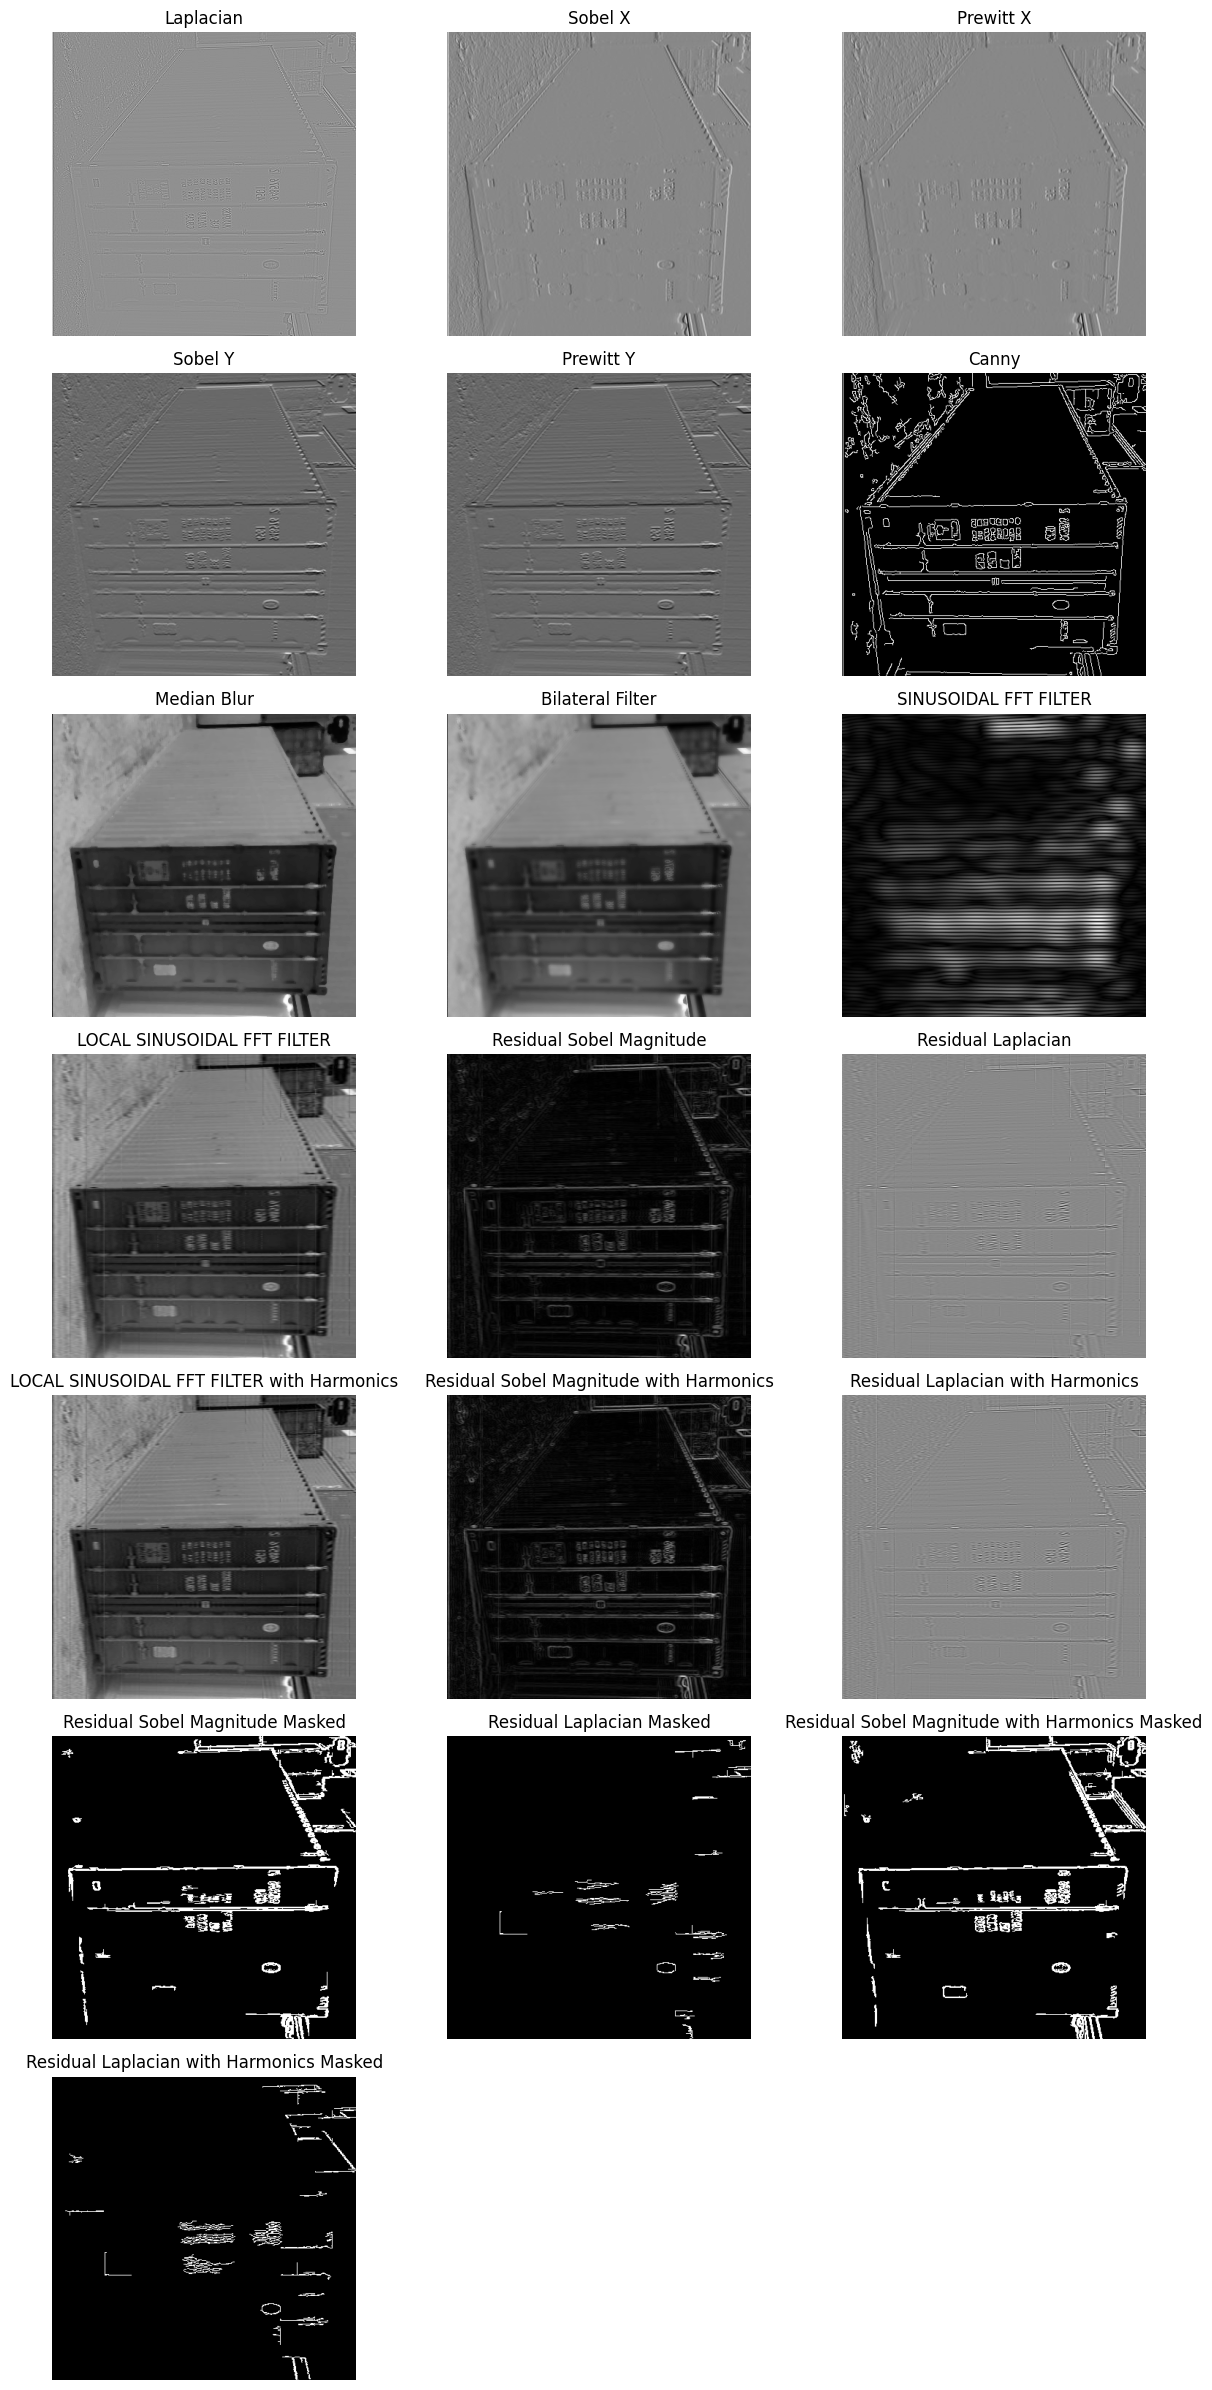

gabor_filter_done == False


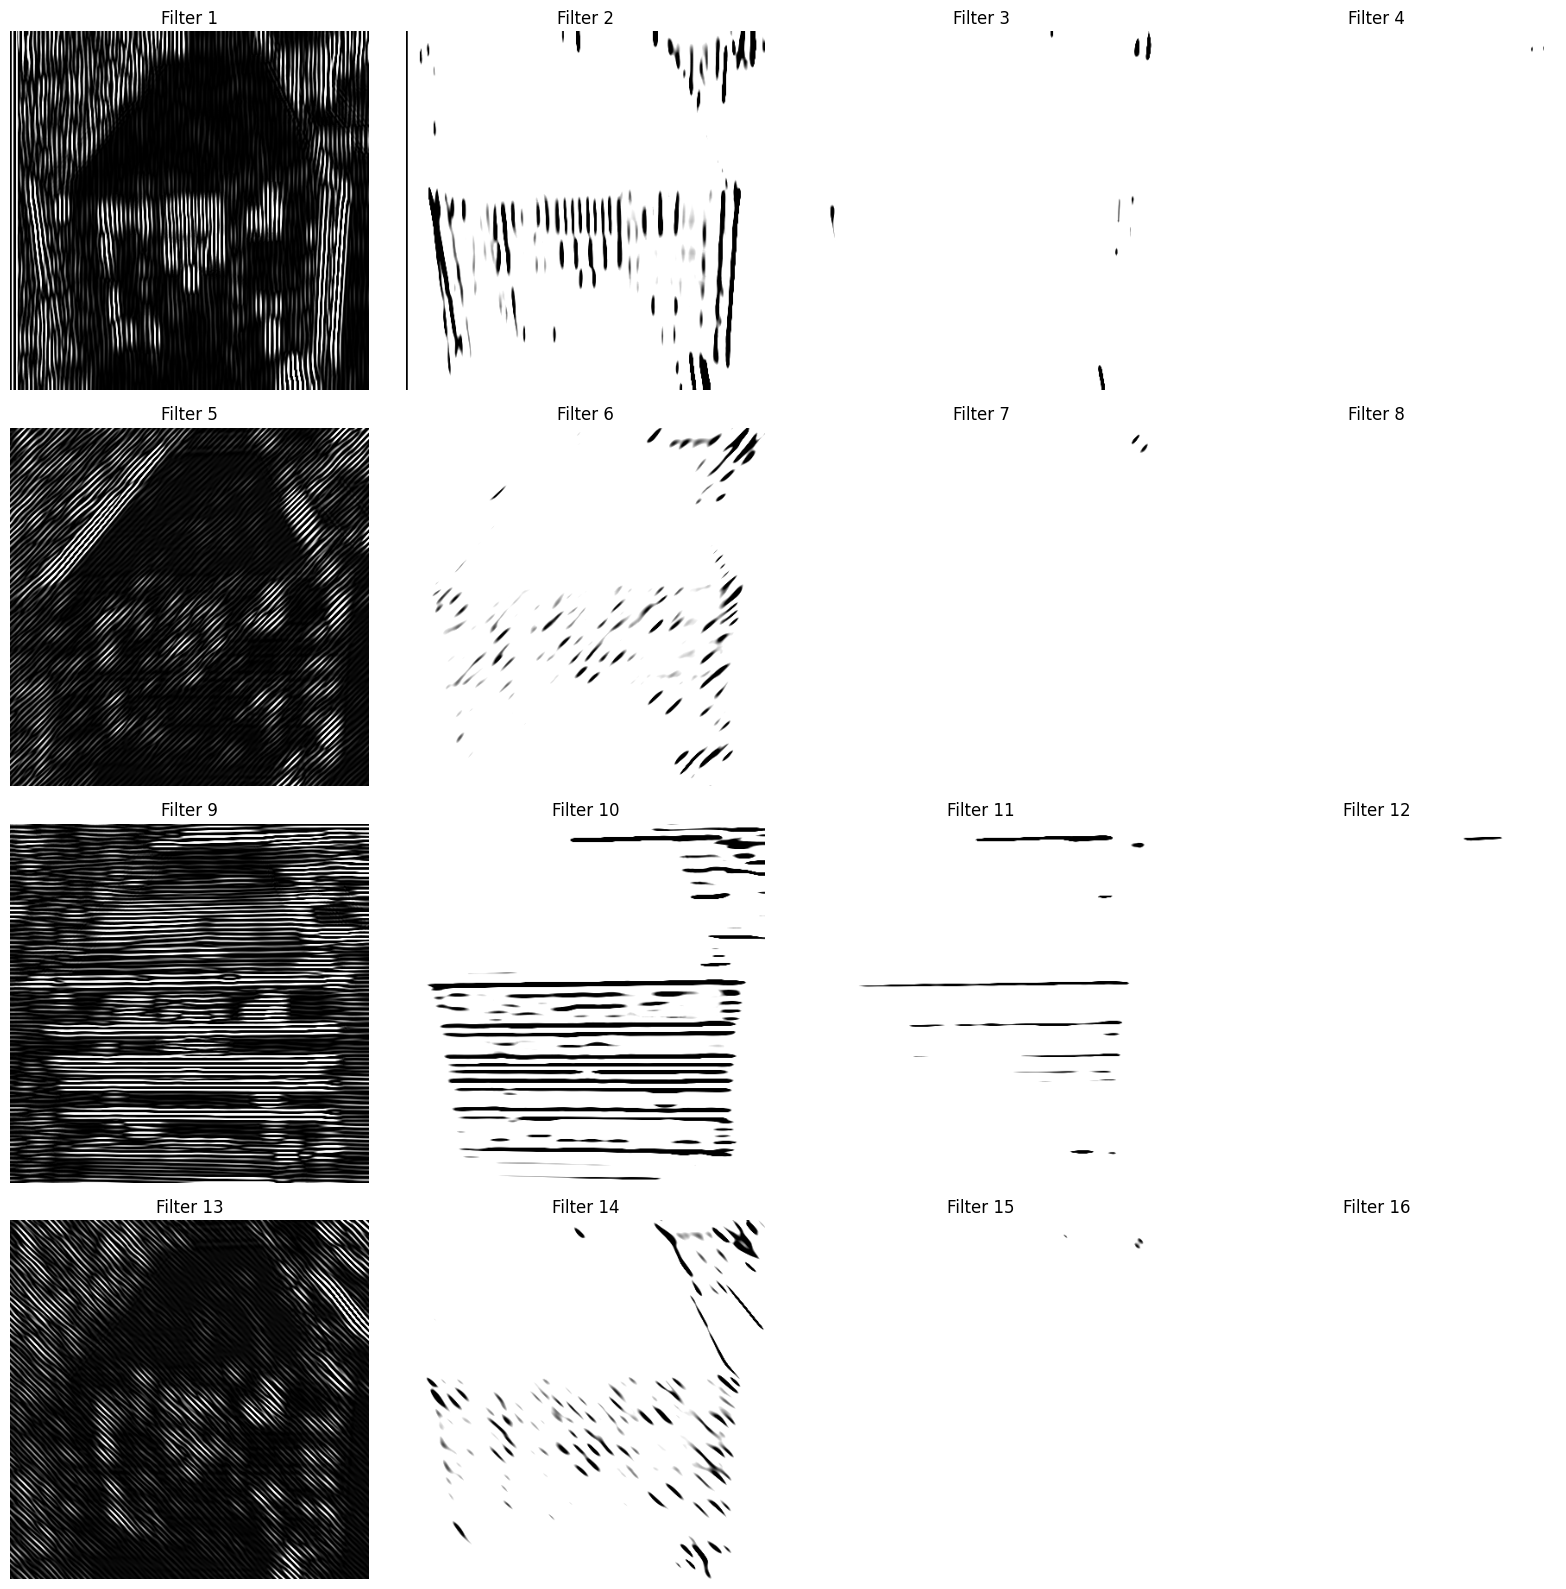

In [15]:
path = os.path.join(TRAIN_DIR, "not_damaged", "40HC-EXPORT-CONTAINER_jpg.rf.bdec0e7490e82d703eb430172927095b.jpg")
img_filter_obj = Filters(path)
img_filter_obj.plot_filters()

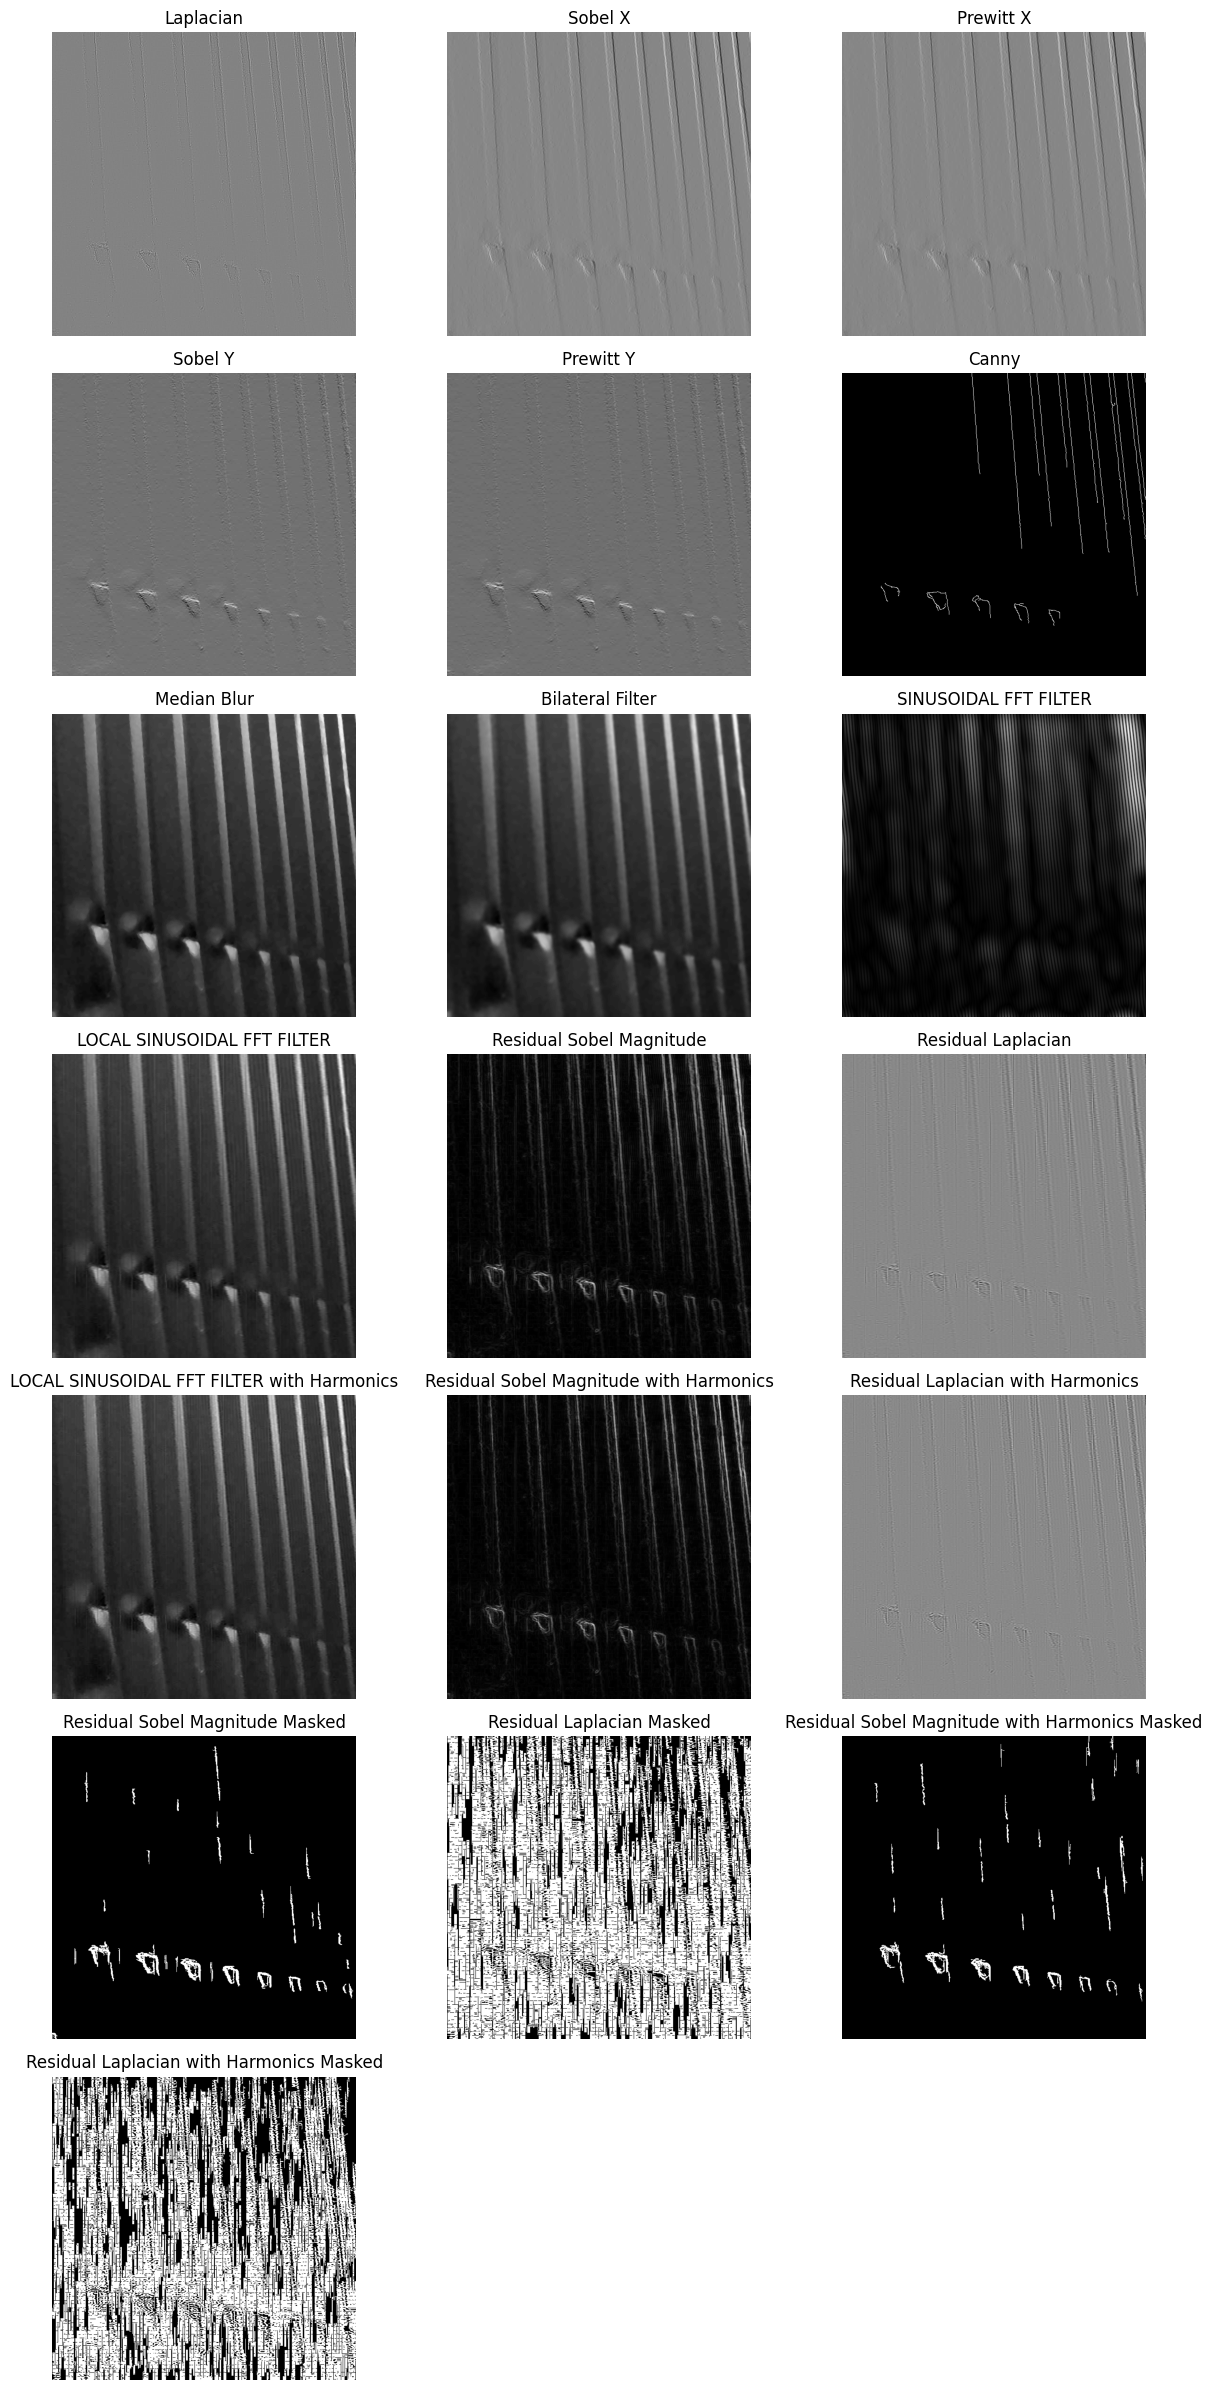

gabor_filter_done == False


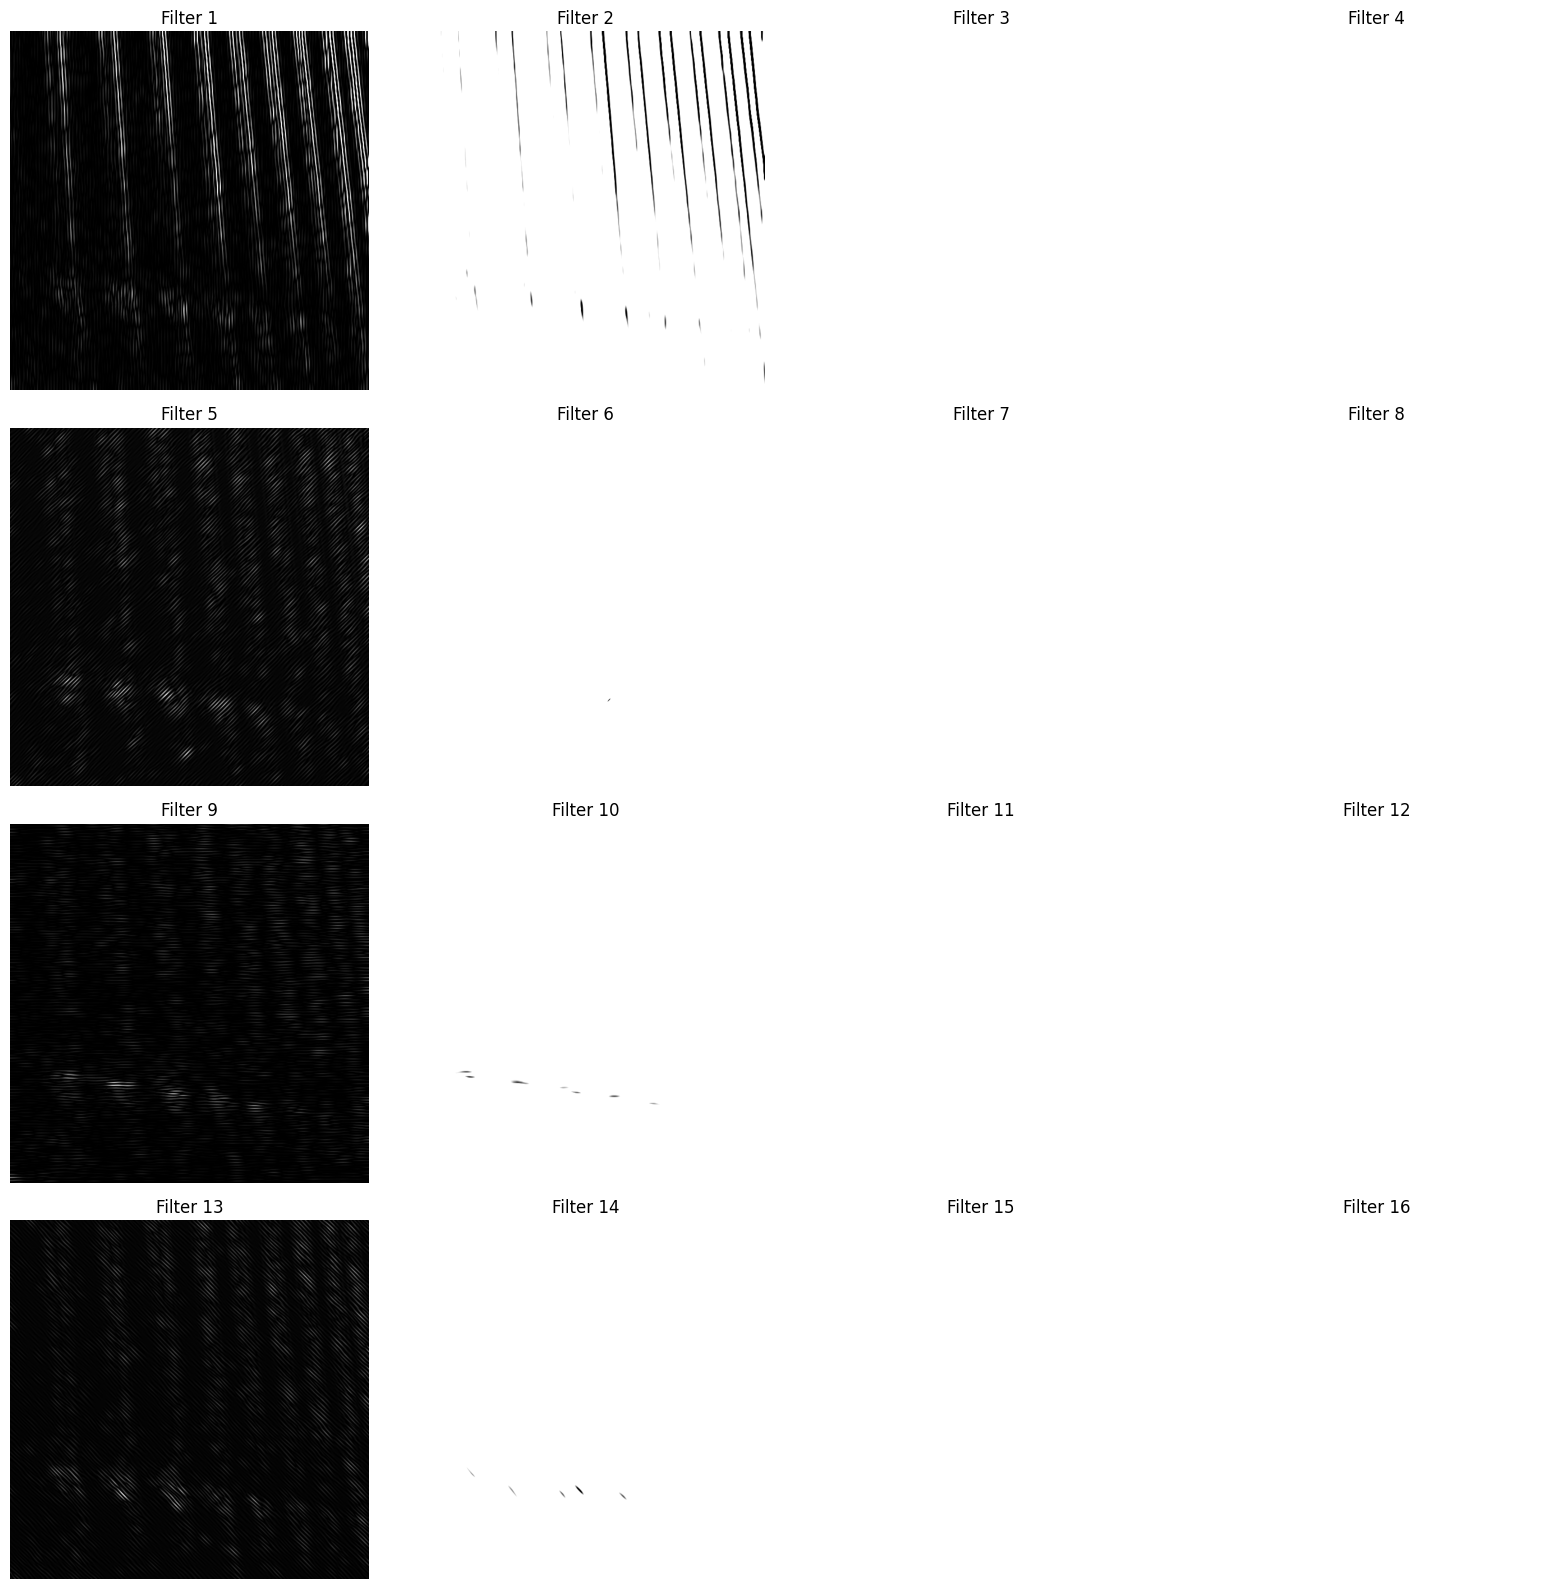

In [16]:
# print(cv2.getStructuringElement(cv2.MORPH_RECT,(3,5)))
path = os.path.join(VALID_DIR, "damaged", "ContainerDamage_1169.jpg")
img_filter_obj = Filters(path)
img_filter_obj.plot_filters()

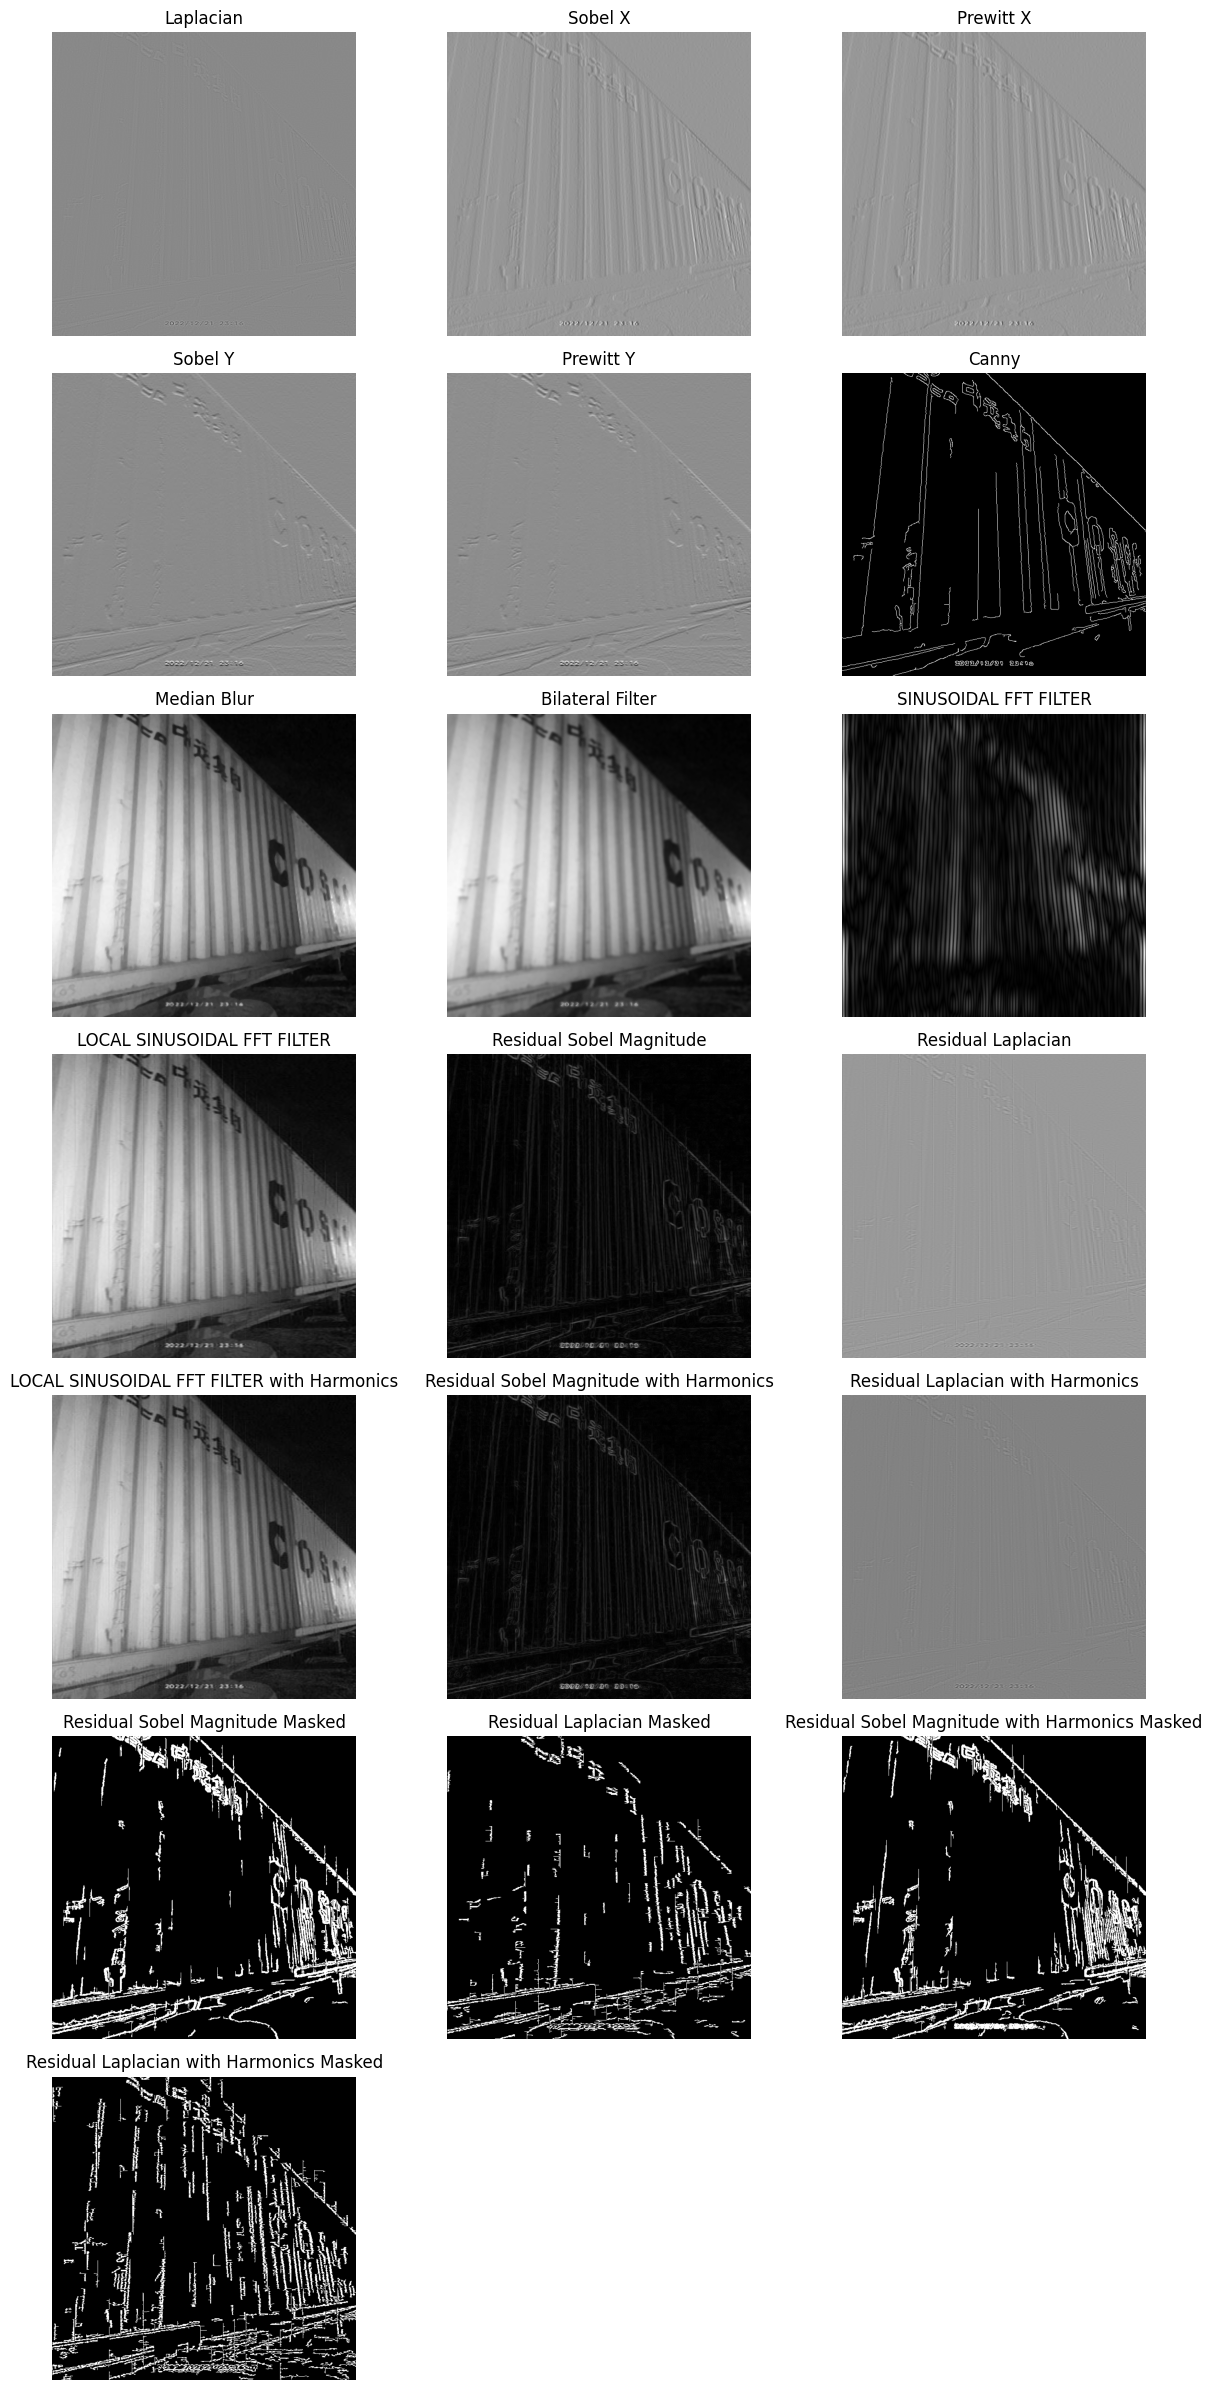

gabor_filter_done == False


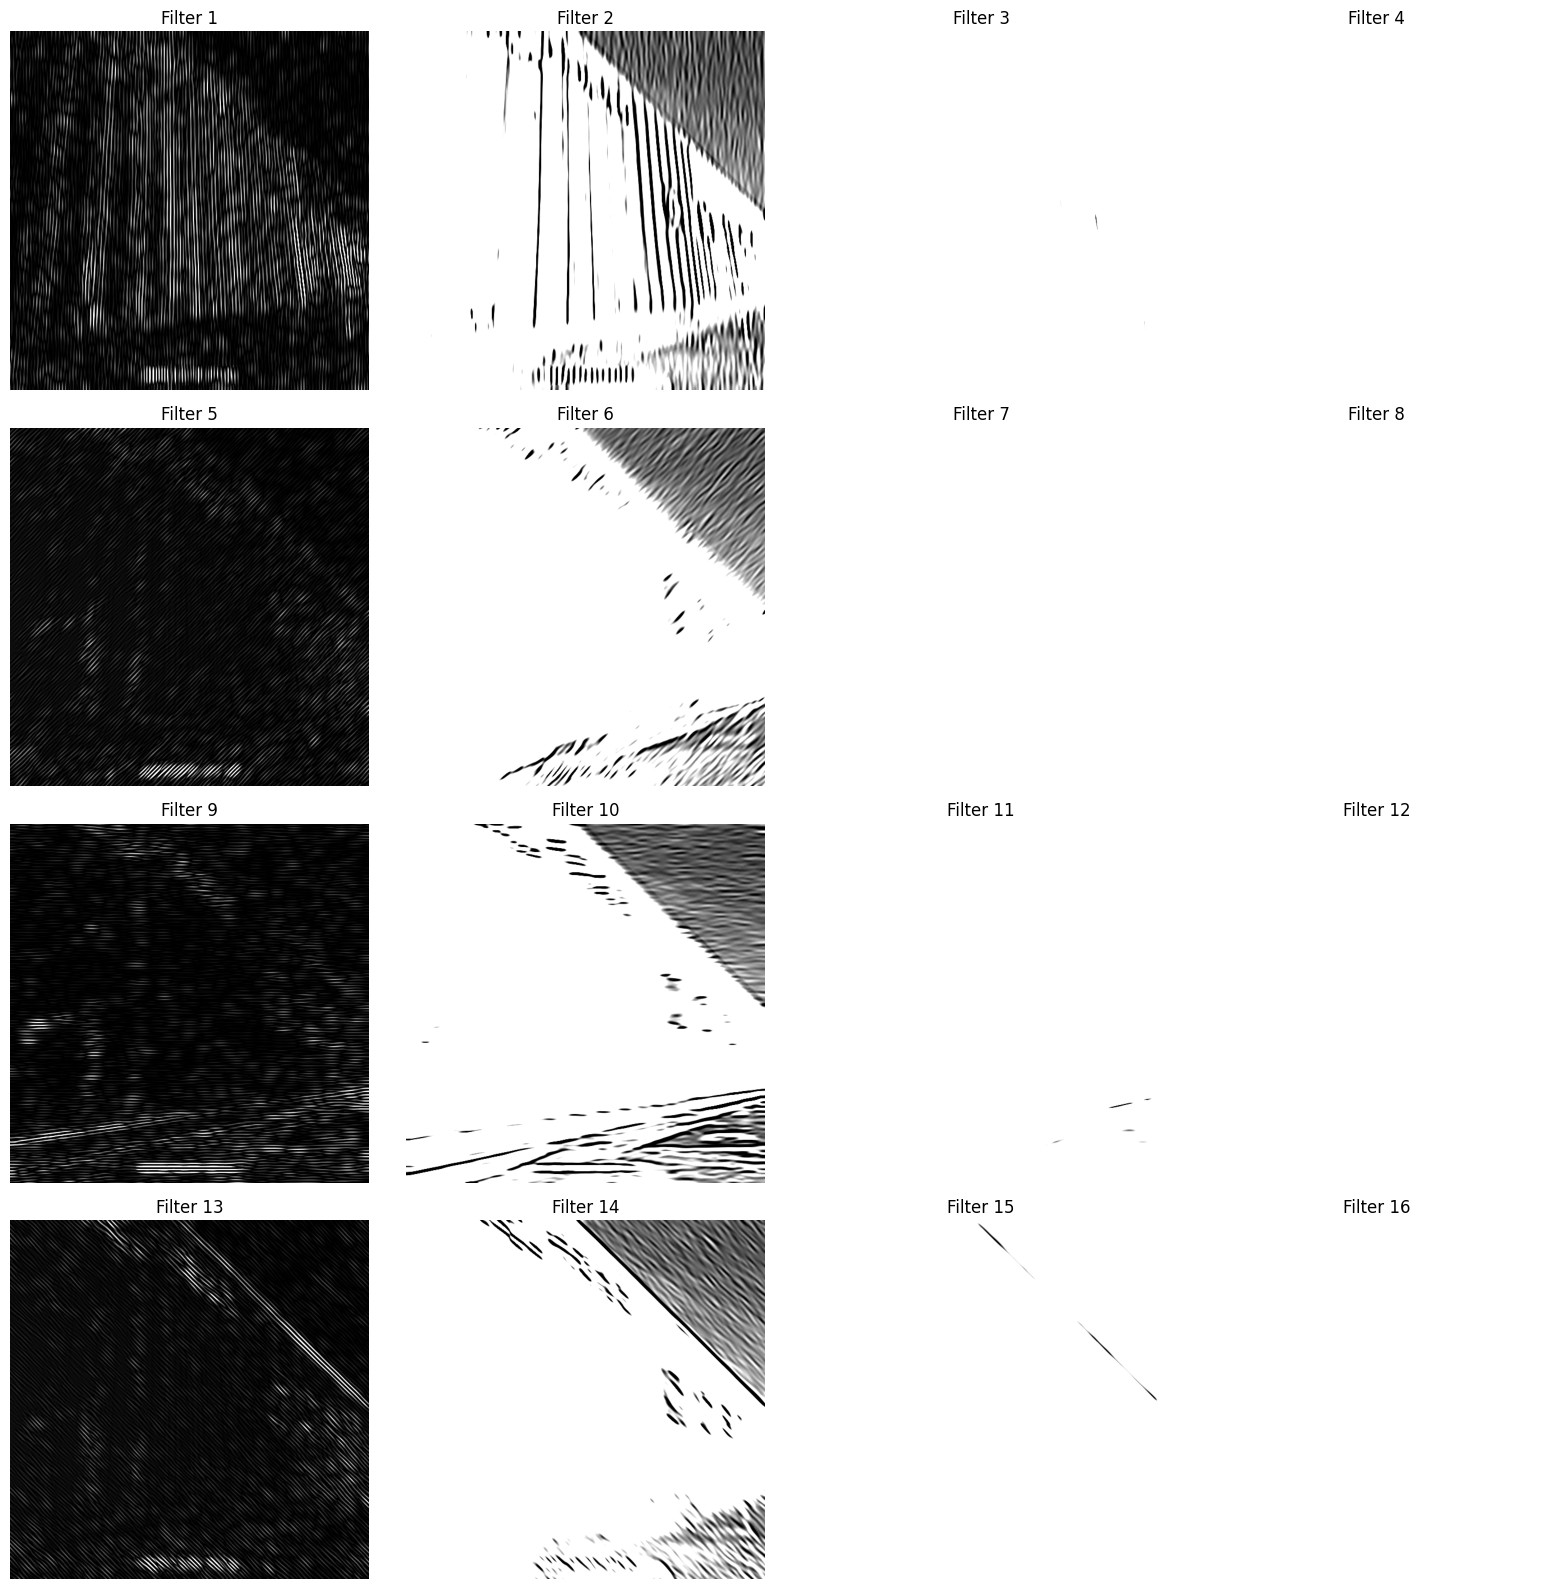

In [17]:
path = os.path.join(VALID_DIR, "not_damaged", "CBHU9477418-2-_jpg.rf.b4e8dca651f6eef945f8b00e86c1d6bf.jpg")
img_filter_obj = Filters(path)
img_filter_obj.plot_filters()

In [18]:
"""
%%time

damaged_dir = os.path.join(TRAIN_DIR, "damaged")
not_damaged_dir = os.path.join(TRAIN_DIR, "not_damaged")

damaged_obj = Filters()
not_damaged_obj = Filters()

lap_norm_damaged = []
sobelX_output_norm_damaged = []
prewittX_filter_output_norm_damaged = []
sobelY_output_norm_damaged = []
prewittY_filter_output_norm_damaged = []
canny_output_norm_damaged = []
gabor_outputs_damaged = []

lap_norm_not_damaged = []
sobelX_output_norm_not_damaged = []
prewittX_filter_output_norm_not_damaged = []
sobelY_output_norm_not_damaged = []
prewittY_filter_output_norm_not_damaged = []
canny_output_norm_not_damaged = []
gabor_outputs_not_damaged = []

print("Damaged klasörü:")
for fname in os.listdir(damaged_dir):
    if fname.lower().endswith((".jpg", ".jpeg", ".png")):
        damaged_image_name = os.path.join(TRAIN_DIR, "damaged/",fname)
        damaged_obj.img_path = damaged_image_name
        damaged_obj.run_filters()
        damaged_obj.apply_gabor_filters()
        lap_norm_damaged.append(damaged_obj.lap_norm)
        sobelX_output_norm_damaged.append(damaged_obj.sobelX_output_norm)
        prewittX_filter_output_norm_damaged.append(damaged_obj.prewittX_filter_output_norm)
        sobelY_output_norm_damaged.append(damaged_obj.sobelY_output_norm)
        prewittY_filter_output_norm_damaged.append(damaged_obj.prewittY_filter_output_norm)
        canny_output_norm_damaged.append(damaged_obj.canny_output_norm)
        gabor_outputs_damaged.append(damaged_obj.gabor_outputs)

print("\nNot Damaged klasörü:")
for fname in os.listdir(not_damaged_dir):
    if fname.lower().endswith((".jpg", ".jpeg", ".png")):
        not_damaged_image_name = os.path.join(TRAIN_DIR, "not_damaged/",fname)
        not_damaged_obj.img_path = damaged_image_name
        not_damaged_obj.run_filters()
        not_damaged_obj.apply_gabor_filters()
        lap_norm_not_damaged.append(not_damaged_obj.lap_norm)
        sobelX_output_norm_not_damaged.append(not_damaged_obj.sobelX_output_norm)
        prewittX_filter_output_norm_not_damaged.append(not_damaged_obj.prewittX_filter_output_norm)
        sobelY_output_norm_not_damaged.append(not_damaged_obj.sobelY_output_norm)
        prewittY_filter_output_norm_not_damaged.append(not_damaged_obj.prewittY_filter_output_norm)
        canny_output_norm_not_damaged.append(not_damaged_obj.canny_output_norm)
        gabor_outputs_not_damaged.append(not_damaged_obj.gabor_outputs)
"""

'\n%%time\n\ndamaged_dir = os.path.join(TRAIN_DIR, "damaged")\nnot_damaged_dir = os.path.join(TRAIN_DIR, "not_damaged")\n\ndamaged_obj = Filters()\nnot_damaged_obj = Filters()\n\nlap_norm_damaged = []\nsobelX_output_norm_damaged = []\nprewittX_filter_output_norm_damaged = []\nsobelY_output_norm_damaged = []\nprewittY_filter_output_norm_damaged = []\ncanny_output_norm_damaged = []\ngabor_outputs_damaged = []\n\nlap_norm_not_damaged = []\nsobelX_output_norm_not_damaged = []\nprewittX_filter_output_norm_not_damaged = []\nsobelY_output_norm_not_damaged = []\nprewittY_filter_output_norm_not_damaged = []\ncanny_output_norm_not_damaged = []\ngabor_outputs_not_damaged = []\n\nprint("Damaged klasörü:")\nfor fname in os.listdir(damaged_dir):\n    if fname.lower().endswith((".jpg", ".jpeg", ".png")):\n        damaged_image_name = os.path.join(TRAIN_DIR, "damaged/",fname)\n        damaged_obj.img_path = damaged_image_name\n        damaged_obj.run_filters()\n        damaged_obj.apply_gabor_filters(

In [19]:
"""
%%time
from concurrent.futures import ThreadPoolExecutor
import os

def process_image(img_path):
    obj = Filters()
    obj.img_path = img_path
    obj.run_filters()
    obj.apply_gabor_filters()

    return {
        "lap": obj.lap_norm,
        "sobelX": obj.sobelX_output_norm,
        "prewittX": obj.prewittX_filter_output_norm,
        "sobelY": obj.sobelY_output_norm,
        "prewittY": obj.prewittY_filter_output_norm,
        "canny": obj.canny_output_norm,
        "gabor": obj.gabor_outputs
    }

damaged_dir = os.path.join(TRAIN_DIR, "damaged")
not_damaged_dir = os.path.join(TRAIN_DIR, "not_damaged")

# sonuç listeleri
lap_norm_damaged = []
sobelX_output_norm_damaged = []
prewittX_filter_output_norm_damaged = []
sobelY_output_norm_damaged = []
prewittY_filter_output_norm_damaged = []
canny_output_norm_damaged = []
gabor_outputs_damaged = []

lap_norm_not_damaged = []
sobelX_output_norm_not_damaged = []
prewittX_filter_output_norm_not_damaged = []
sobelY_output_norm_not_damaged = []
prewittY_filter_output_norm_not_damaged = []
canny_output_norm_not_damaged = []
gabor_outputs_not_damaged = []


# ----------------------------------------
# DAMAGED paralel işleme
# ----------------------------------------
damaged_paths = [
    os.path.join(damaged_dir, f)
    for f in os.listdir(damaged_dir)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

with ThreadPoolExecutor() as executor:
    results_damaged = list(executor.map(process_image, damaged_paths))

for r in results_damaged:
    lap_norm_damaged.append(r["lap"])
    sobelX_output_norm_damaged.append(r["sobelX"])
    prewittX_filter_output_norm_damaged.append(r["prewittX"])
    sobelY_output_norm_damaged.append(r["sobelY"])
    prewittY_filter_output_norm_damaged.append(r["prewittY"])
    canny_output_norm_damaged.append(r["canny"])
    gabor_outputs_damaged.append(r["gabor"])


# ----------------------------------------
# NOT DAMAGED paralel işleme
# ----------------------------------------
not_damaged_paths = [
    os.path.join(not_damaged_dir, f)
    for f in os.listdir(not_damaged_dir)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

with ThreadPoolExecutor() as executor:
    results_not_damaged = list(executor.map(process_image, not_damaged_paths))

for r in results_not_damaged:
    lap_norm_not_damaged.append(r["lap"])
    sobelX_output_norm_not_damaged.append(r["sobelX"])
    prewittX_filter_output_norm_not_damaged.append(r["prewittX"])
    sobelY_output_norm_not_damaged.append(r["sobelY"])
    prewittY_filter_output_norm_not_damaged.append(r["prewittY"])
    canny_output_norm_not_damaged.append(r["canny"])
    gabor_outputs_not_damaged.append(r["gabor"])
    """

'\n%%time\nfrom concurrent.futures import ThreadPoolExecutor\nimport os\n\ndef process_image(img_path):\n    obj = Filters()\n    obj.img_path = img_path\n    obj.run_filters()\n    obj.apply_gabor_filters()\n\n    return {\n        "lap": obj.lap_norm,\n        "sobelX": obj.sobelX_output_norm,\n        "prewittX": obj.prewittX_filter_output_norm,\n        "sobelY": obj.sobelY_output_norm,\n        "prewittY": obj.prewittY_filter_output_norm,\n        "canny": obj.canny_output_norm,\n        "gabor": obj.gabor_outputs\n    }\n\ndamaged_dir = os.path.join(TRAIN_DIR, "damaged")\nnot_damaged_dir = os.path.join(TRAIN_DIR, "not_damaged")\n\n# sonuç listeleri\nlap_norm_damaged = []\nsobelX_output_norm_damaged = []\nprewittX_filter_output_norm_damaged = []\nsobelY_output_norm_damaged = []\nprewittY_filter_output_norm_damaged = []\ncanny_output_norm_damaged = []\ngabor_outputs_damaged = []\n\nlap_norm_not_damaged = []\nsobelX_output_norm_not_damaged = []\nprewittX_filter_output_norm_not_damag

In [20]:
# FEATURE EXTRACTION #

def _safe_stats(x):
    """Return robust scalar stats for an image-like array."""
    x = np.asarray(x)
    if x.size == 0:
        return [0.0, 0.0, 0.0, 0.0]
    x = x.astype(np.float32)

    return [
        float(np.mean(x)),
        float(np.std(x)),
        float(np.percentile(x, 95)),
        float(np.max(x)),
    ]

def _mask_stats(mask):
    """Stats for a binary mask (0/255 or 0/1)."""
    m = (np.asarray(mask) > 0).astype(np.uint8)
    area_ratio = float(m.mean())  # since m is 0/1
    # connected components
    num, labels, stats, _ = cv2.connectedComponentsWithStats((m * 255).astype(np.uint8), connectivity=8)
    areas = []
    aspects = []
    for i in range(1, num):
        x, y, w, h, area = stats[i]
        areas.append(area)
        aspects.append(max(w, h) / (min(w, h) + 1e-6))
    if len(areas) == 0:
        return [area_ratio, 0.0, 0.0, 0.0]
    return [
        area_ratio,
        float(len(areas)),
        float(np.max(areas)),
        float(np.mean(aspects)),
    ]

def extract_features_from_filters_obj(fobj):
    """
    Optimized per-image feature vector for container damage detection.
    Focuses on:
      - Local FFT spectral residuals
      - Residual edge energy
      - Harmonic-suppressed responses
      - Geometric damage masks
    """
    feats = []

    # ---------- FFT BASED (LOCAL & HARMONIC) ----------
    for attr in [
        "fft_residual_local_output_norm",
        "fft_residual_local_output_norm_with_harmonics",
    ]:
        if hasattr(fobj, attr) and getattr(fobj, attr) is not None:
            feats += _safe_stats(getattr(fobj, attr))
        else:
            feats += [0.0, 0.0, 0.0, 0.0]

    # ---------- RESIDUAL EDGE ENERGY ----------
    for attr in [
        "residual_sobel_mag",
        "residual_laplacian",
        "residual_sobel_mag_with_harmonics",
        "residual_laplacian_with_harmonics",
    ]:
        if hasattr(fobj, attr) and getattr(fobj, attr) is not None:
            feats += _safe_stats(getattr(fobj, attr))
        else:
            feats += [0.0, 0.0, 0.0, 0.0]

    # ---------- MASK / GEOMETRIC DAMAGE ----------
    for attr in [
        "residual_sobel_mag_masked",
        "residual_laplacian_masked",
        "residual_sobel_mag_with_harmonics_masked",
        "residual_laplacian_with_harmonics_masked",
    ]:
        if hasattr(fobj, attr) and getattr(fobj, attr) is not None:
            feats += _mask_stats(getattr(fobj, attr))
        else:
            feats += [0.0, 0.0, 0.0, 0.0]

    return np.array(feats, dtype=np.float32)

def featurize_image_path(img_path):
    """Run your existing Filters pipeline and return a feature vector."""
    fobj = Filters(img_path)
    fobj.run_filters()
    return extract_features_from_filters_obj(fobj)

# DATASET LOADER #
def _list_images(folder):
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
    if not os.path.isdir(folder):
        return []
    return [os.path.join(folder, f) for f in sorted(os.listdir(folder)) if f.lower().endswith(exts)]



def build_dataset(root_dir):
    """
    Returns X, y, paths.
    Expected:
      root_dir/healthy/*
      root_dir/damaged/*
    Labels: healthy=0, damaged=1
    """
    healthy_dir = os.path.join(root_dir, "not_damaged")
    damaged_dir = os.path.join(root_dir, "damaged")

    healthy_paths = _list_images(healthy_dir)
    damaged_paths = _list_images(damaged_dir)

    # print(healthy_paths)
    # print(damaged_paths)

    X_list, y_list, p_list = [], [], []

    #  print("healthy_paths: " + str(len(healthy_paths)))

    #     print("damaged_paths: " + str(len(damaged_paths)))
    
    for p in healthy_paths:
        try:
            X_list.append(featurize_image_path(p))
            y_list.append(0)
            p_list.append(p)
        except Exception as e:
            print(f"[SKIP healthy] {p} -> {e}")

    for p in damaged_paths:
        try:
            X_list.append(featurize_image_path(p))
            y_list.append(1)
            p_list.append(p)
        except Exception as e:
            print(f"[SKIP damaged] {p} -> {e}")

    X = np.vstack(X_list) if len(X_list) else np.zeros((0, 20), dtype=np.float32)
    y = np.array(y_list, dtype=np.int64)
    return X, y, p_list

# BUILD TRAIN/VALID SETS #

start = time.perf_counter()

X_train, y_train, train_paths = build_dataset(TRAIN_DIR)
X_valid, y_valid, valid_paths = build_dataset(VALID_DIR)
X_test, y_test, test_paths = build_dataset(TEST_DIR)


end = time.perf_counter()
elapsed = end - start

minutes = int(elapsed // 60)
seconds = int(elapsed % 60)

print(f"Elapsed time: {minutes} min {seconds} sec")

Elapsed time: 31 min 29 sec


In [21]:
# X_train.shape # (4415, 40)
# y_train.shape # (4415,)
# X_test.shape # (452, 40)

In [22]:
print("Train:", X_train.shape, " Valid:", X_valid.shape, " Test:", X_test.shape)
print("Train damaged ratio:", float(y_train.mean()) if len(y_train) else None)
print("Valid damaged ratio:", float(y_valid.mean()) if len(y_valid) else None)
print("Test damaged ratio:", float(y_test.mean()) if len(y_test) else None)

# TRAIN MODELS #

# Goal:
# - Use VALID set ONLY to choose hyperparameters / best model.
# - Keep TEST set untouched for the final evaluation.

from sklearn.metrics import f1_score

def _score_on_valid(model, Xv, yv):
    pred = model.predict(Xv)
    # Macro-F1 is usually more informative than accuracy under class imbalance
    return float(f1_score(yv, pred, average="macro")), float(accuracy_score(yv, pred))

# Candidate models + small hyperparameter grids (fast baselines)
candidates = []

# 1) SVM (RBF)
for C in [1.0, 5.0, 10.0]:
    for gamma in ["scale", 0.01, 0.001]:
        candidates.append((
            f"SVM_RBF(C={C},gamma={gamma})",
            Pipeline([
                ("scaler", StandardScaler()),
                ("clf", SVC(kernel="rbf", C=C, gamma=gamma, probability=True, class_weight="balanced"))
            ])
        ))

# 2) Random Forest
for n_estimators in [200, 300, 500]:
    for max_depth in [None, 20, 40]:
        candidates.append((
            f"RandomForest(n={n_estimators},depth={max_depth})",
            RandomForestClassifier(
                n_estimators=n_estimators,
                random_state=42,
                class_weight="balanced_subsample",
                max_depth=max_depth,
                n_jobs=-1
            )
        ))

# 3) Logistic Regression
for C in [0.5, 1.0, 2.0, 5.0]:
    candidates.append((
        f"LogReg(C={C})",
        Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(C=C, max_iter=2000, class_weight="balanced"))
        ])
    ))

# Train on TRAIN, select on VALID
best = {"name": None, "model": None, "macro_f1": -1.0, "acc": -1.0}
trained = {}

print("Tuning on VALID (train on TRAIN only)...")
for name, model in candidates:
    model.fit(X_train, y_train)
    macro_f1, acc = _score_on_valid(model, X_valid, y_valid)
    trained[name] = model  # keep the fitted candidate if you want to inspect later
    if macro_f1 > best["macro_f1"]:
        best.update({"name": name, "model": model, "macro_f1": macro_f1, "acc": acc})

print("\nBEST on VALID:")
print("  Model:", best["name"])
print("  VALID Macro-F1:", best["macro_f1"])
print("  VALID Accuracy:", best["acc"])

# Final refit on TRAIN+VALID using the chosen best configuration
X_train_final = np.vstack([X_train, X_valid]) if len(X_valid) else X_train
y_train_final = np.concatenate([y_train, y_valid]) if len(y_valid) else y_train

best_model = best["model"]
best_model.fit(X_train_final, y_train_final)

# Expose a clean handle for downstream use
trained = {"BEST": best_model, best["name"]: best_model}

print("\nDone. Final model is trained on TRAIN+VALID; TEST is kept for final evaluation.")

# EVALUATION (VALID FOR TUNING, TEST FOR FINAL)      #
def evaluate(model, X, y, title=""):
    pred = model.predict(X)
    print("\n" + "="*60)
    print(title)
    print("Accuracy:", accuracy_score(y, pred))
    print("Confusion matrix:\n", confusion_matrix(y, pred))
    print(classification_report(y, pred, target_names=["healthy(0)", "damaged(1)"]))

# 1) Report the selected model's performance on VALID (used for tuning)
evaluate(trained["BEST"], X_valid, y_valid, title="VALID RESULTS (used for model selection) - BEST")

# 2) Final, unbiased report on TEST
evaluate(trained["BEST"], X_test, y_test, title="TEST RESULTS (final evaluation) - BEST")

# PREDICT SINGLE IMAGE (DRIVER)       #
def predict_container(img_path, model_name="BEST", threshold=0.5):
    model = trained[model_name]
    x = featurize_image_path(img_path).reshape(1, -1)

    # probability if available
    if hasattr(model, "predict_proba"):
        prob = float(model.predict_proba(x)[0, 1])
    else:
        # fallback: treat decision_function as score
        score = float(model.decision_function(x)[0])
        prob = 1.0 / (1.0 + np.exp(-score))

    label = int(prob >= threshold)
    return label, prob

# Example:
# test_path = os.path.join(VALID_DIR, "damaged", "ContainerDamage_1169.jpg")
# label, prob = predict_container(test_path, model_name="SVM_RBF", threshold=0.5)
# print("Pred:", "DAMAGED" if label==1 else "HEALTHY", "prob_damaged=", prob)

Train: (4415, 40)  Valid: (527, 40)  Test: (452, 40)
Train damaged ratio: 0.6097395243488108
Valid damaged ratio: 0.6489563567362429
Test damaged ratio: 0.7477876106194691
Tuning on VALID (train on TRAIN only)...

BEST on VALID:
  Model: RandomForest(n=500,depth=20)
  VALID Macro-F1: 0.9127565982404692
  VALID Accuracy: 0.920303605313093

Done. Final model is trained on TRAIN+VALID; TEST is kept for final evaluation.

VALID RESULTS (used for model selection) - BEST
Accuracy: 1.0
Confusion matrix:
 [[185   0]
 [  0 342]]
              precision    recall  f1-score   support

  healthy(0)       1.00      1.00      1.00       185
  damaged(1)       1.00      1.00      1.00       342

    accuracy                           1.00       527
   macro avg       1.00      1.00      1.00       527
weighted avg       1.00      1.00      1.00       527


TEST RESULTS (final evaluation) - BEST
Accuracy: 0.9424778761061947
Confusion matrix:
 [[105   9]
 [ 17 321]]
              precision    recall  f

In [23]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

model = Sequential([
    Dense(64, activation='relu', input_shape=(40,)),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

y_valid_proba = model.predict(X_valid_scaled)
y_valid_pred = (y_valid_proba >= 0.5).astype(int)
print(y_valid_proba.shape)  # (452, 1)
print(y_valid_pred.shape)   # (452, 1)

Epoch 1/50


I0000 00:00:1767904060.836897     112 service.cc:148] XLA service 0x77fd840250e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767904060.840751     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767904060.840776     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767904061.367978     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


 74/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6978 - loss: 0.5767

I0000 00:00:1767904063.265149     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7201 - loss: 0.5462 - val_accuracy: 0.8698 - val_loss: 0.3523
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8143 - loss: 0.3886 - val_accuracy: 0.9196 - val_loss: 0.2651
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8377 - loss: 0.3367 - val_accuracy: 0.8924 - val_loss: 0.2982
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8415 - loss: 0.3276 - val_accuracy: 0.9366 - val_loss: 0.2353
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8559 - loss: 0.3088 - val_accuracy: 0.9003 - val_loss: 0.2929
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8642 - loss: 0.2938 - val_accuracy: 0.9253 - val_loss: 0.2410
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8598 - loss: 0.2902 - val_accuracy: 0.9162 - val_loss: 0.2346
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8549 - loss: 0.3058 - val_accuracy: 0.8890 - val

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    print(cm)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Predicted 0', 'Predicted 1'],
        yticklabels=['Actual 0', 'Actual 1']
    )
    
    plt.xlabel('Tahmin Edilen Sınıf')
    plt.ylabel('Gerçek Sınıf')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    print(classification_report(y, y_pred))

# Train Result

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[1649   74]
 [ 199 2493]]


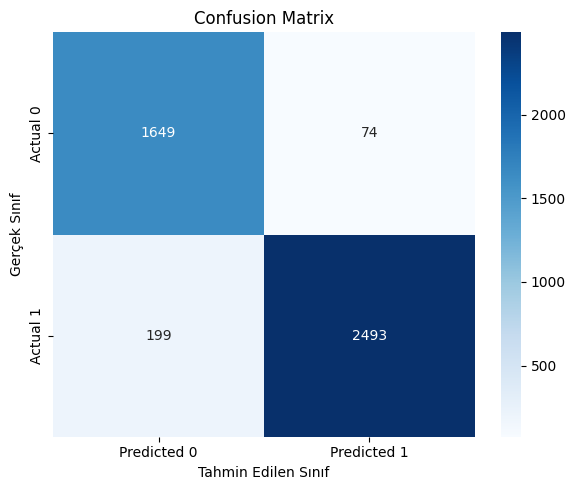

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1723
           1       0.97      0.93      0.95      2692

    accuracy                           0.94      4415
   macro avg       0.93      0.94      0.94      4415
weighted avg       0.94      0.94      0.94      4415



In [25]:
y_train_proba = model.predict(X_train_scaled)
y_train_pred = (y_train_proba >= 0.5).astype(int)
plot_confusion_matrix(y_train, y_train_pred)

# Validation Result

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[177   8]
 [ 54 288]]


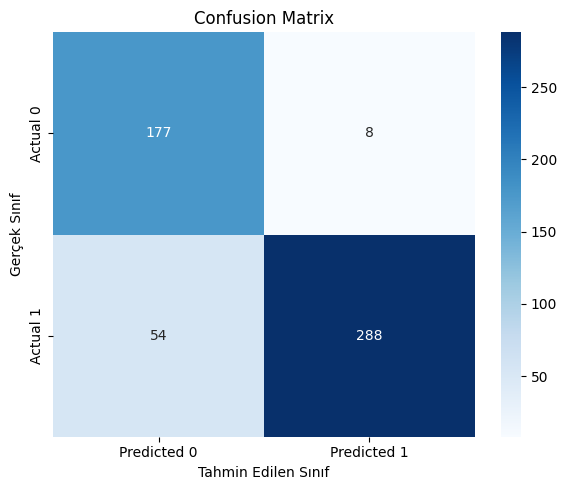

              precision    recall  f1-score   support

           0       0.77      0.96      0.85       185
           1       0.97      0.84      0.90       342

    accuracy                           0.88       527
   macro avg       0.87      0.90      0.88       527
weighted avg       0.90      0.88      0.88       527



In [26]:
X_valid_scaled = scaler.transform(X_valid)
y_valid_proba = model.predict(X_valid_scaled)
y_valid_pred = (y_valid_proba >= 0.5).astype(int)
plot_confusion_matrix(y_valid, y_valid_pred)

# Test Result

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[109   5]
 [ 32 306]]


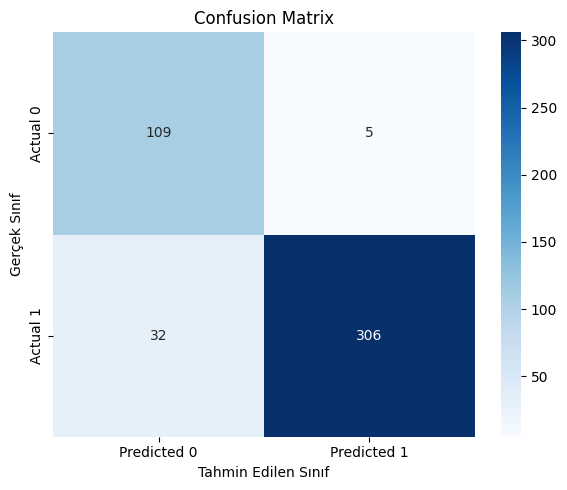

              precision    recall  f1-score   support

           0       0.77      0.96      0.85       114
           1       0.98      0.91      0.94       338

    accuracy                           0.92       452
   macro avg       0.88      0.93      0.90       452
weighted avg       0.93      0.92      0.92       452



In [27]:
X_test_scaled = scaler.transform(X_test)
y_test_proba = model.predict(X_test_scaled)
y_test_pred = (y_test_proba >= 0.5).astype(int)
plot_confusion_matrix(y_test, y_test_pred)

Train ROC-AUC Curve


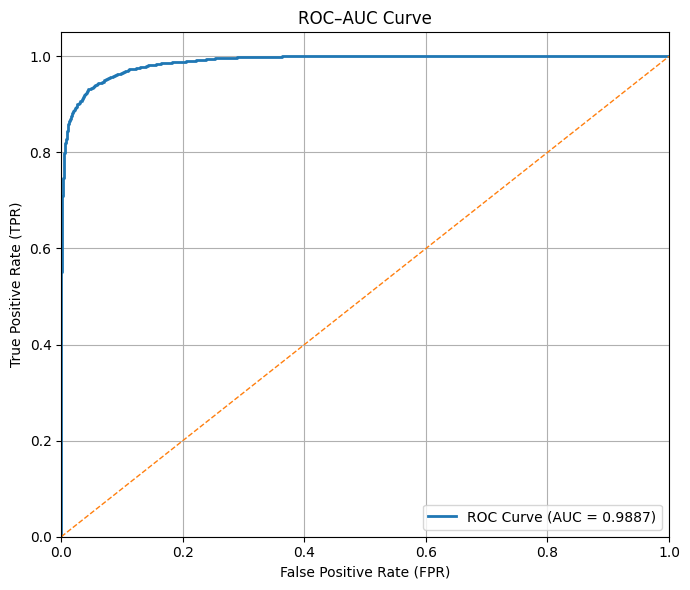

Valid ROC-AUC Curve


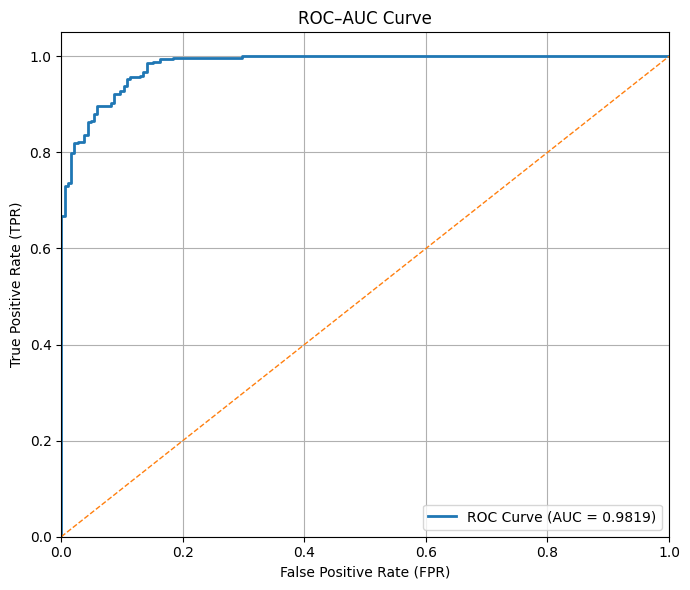

Test ROC-AUC Curve


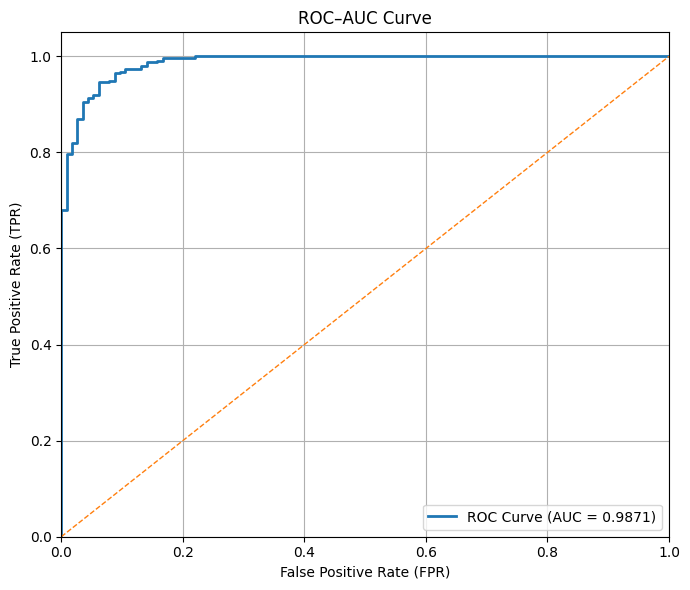

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
def plot_roc_curve(y_test, y_test_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC–AUC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
print("Train ROC-AUC Curve")
plot_roc_curve(y_train, y_train_proba)
print("Valid ROC-AUC Curve")
plot_roc_curve(y_valid, y_valid_proba)
print("Test ROC-AUC Curve")
plot_roc_curve(y_test, y_test_proba)

In [29]:
from sklearn.metrics import accuracy_score

# ===== Train Accuracy =====
y_train_proba = model.predict(X_train_scaled)
y_train_pred = (y_train_proba >= 0.5).astype(int)

train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_accuracy:.4f}")


# ===== Validation Accuracy (Keras history üzerinden) =====
val_accuracy = history.history['val_accuracy'][-1]
print(f"Validation Accuracy: {val_accuracy:.4f}")


# ===== Test Accuracy =====
y_test_proba = model.predict(X_test_scaled)
y_test_pred = (y_test_proba >= 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


# ===== Özet =====
print(f"""
Train Accuracy      : {train_accuracy:.4f}
Validation Accuracy : {val_accuracy:.4f}
Test Accuracy       : {test_accuracy:.4f}
""")

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train Accuracy: 0.9382
Validation Accuracy: 0.8641
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test Accuracy: 0.9181

Train Accuracy      : 0.9382
Validation Accuracy : 0.8641
Test Accuracy       : 0.9181



# Feature Importance

In [30]:
FEATURE_NAMES = []

def add_safe_stats_names(prefix):
    return [
        f"{prefix}_mean",
        f"{prefix}_std",
        f"{prefix}_p95",
        f"{prefix}_max",
    ]

def add_mask_stats_names(prefix):
    return [
        f"{prefix}_area_ratio",
        f"{prefix}_num_components",
        f"{prefix}_max_area",
        f"{prefix}_mean_aspect",
    ]

# FFT
FEATURE_NAMES += add_safe_stats_names("fft_residual_local_output_norm")
FEATURE_NAMES += add_safe_stats_names("fft_residual_local_output_norm_with_harmonics")

# Residual edges
FEATURE_NAMES += add_safe_stats_names("residual_sobel_mag")
FEATURE_NAMES += add_safe_stats_names("residual_laplacian")
FEATURE_NAMES += add_safe_stats_names("residual_sobel_mag_with_harmonics")
FEATURE_NAMES += add_safe_stats_names("residual_laplacian_with_harmonics")

# Mask
FEATURE_NAMES += add_mask_stats_names("residual_sobel_mag_masked")
FEATURE_NAMES += add_mask_stats_names("residual_laplacian_masked")
FEATURE_NAMES += add_mask_stats_names("residual_sobel_mag_with_harmonics_masked")
FEATURE_NAMES += add_mask_stats_names("residual_laplacian_with_harmonics_masked")

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

model.fit(X_train, y_train)

r = permutation_importance(
    model,
    X_valid,
    y_valid,
    n_repeats=20,
    random_state=42,
    scoring="f1"
)

importance_df = pd.DataFrame({
    "feature": FEATURE_NAMES,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std,
}).sort_values("importance_mean", ascending=False)

print(importance_df.head(15))

                                              feature  importance_mean  \
25           residual_sobel_mag_masked_num_components         0.015820   
33  residual_sobel_mag_with_harmonics_masked_num_c...         0.015753   
28               residual_laplacian_masked_area_ratio         0.006950   
24               residual_sobel_mag_masked_area_ratio         0.005816   
32  residual_sobel_mag_with_harmonics_masked_area_...         0.005299   
4   fft_residual_local_output_norm_with_harmonics_...         0.004660   
38  residual_laplacian_with_harmonics_masked_max_area         0.004276   
31              residual_laplacian_masked_mean_aspect         0.003657   
0                 fft_residual_local_output_norm_mean         0.003403   
29           residual_laplacian_masked_num_components         0.003020   
27              residual_sobel_mag_masked_mean_aspect         0.002678   
39  residual_laplacian_with_harmonics_masked_mean_...         0.002511   
36  residual_laplacian_with_harmonics_

In [32]:
def build_flaw_dataset(root_dir,root_dir_heal):
    """
    Returns X, y, paths.
    Expected:
      root_dir/healthy/*
      root_dir/damaged/*
    Labels: healthy=0, damaged=1
    """

    damaged_paths = _list_images(root_dir)
    healthy_dir = os.path.join(root_dir_heal, "not_damaged")

    healthy_paths = _list_images(healthy_dir)

    # print(healthy_paths)
    # print(damaged_paths)

    X_list, y_list, p_list = [], [], []

    #  print("healthy_paths: " + str(len(healthy_paths)))

    #     print("damaged_paths: " + str(len(damaged_paths)))
    
    for p in healthy_paths:
        try:
            X_list.append(featurize_image_path(p))
            y_list.append(0)
            p_list.append(p)
        except Exception as e:
            print(f"[SKIP healthy] {p} -> {e}")
    # print(healthy_paths)
    # print(damaged_paths)

    #  print("healthy_paths: " + str(len(healthy_paths)))

    #     print("damaged_paths: " + str(len(damaged_paths)))

    for p in damaged_paths:
        try:
            X_list.append(featurize_image_path(p))
            y_list.append(1)
            p_list.append(p)
        except Exception as e:
            print(f"[SKIP damaged] {p} -> {e}")

    X = np.vstack(X_list) if len(X_list) else np.zeros((0, 20), dtype=np.float32)
    y = np.array(y_list, dtype=np.int64)
    return X, y, p_list


X_flaw_test, y_flaw_test, test_flaw_paths=build_flaw_dataset(r"/kaggle/input/sssssssssss/kaggle/working/output/categorized_images/corrosion",TEST_DIR)

model.fit(X_train, y_train)

r = permutation_importance(
    model,
    X_flaw_test,
    y_flaw_test,
    n_repeats=20,
    random_state=42,
    scoring="f1"
)

importance_df = pd.DataFrame({
    "feature": FEATURE_NAMES,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std,
}).sort_values("importance_mean", ascending=False)

print(importance_df.head(15))

print("########################################################################")
print("########################################################################")
print("########################################################################")
print("########################################################################")

X_flaw_test, y_flaw_test, test_flaw_paths=build_flaw_dataset(r"/kaggle/input/sssssssssss/kaggle/working/output/categorized_images/crack",TEST_DIR)

r = permutation_importance(
    model,
    X_flaw_test,
    y_flaw_test,
    n_repeats=20,
    random_state=42,
    scoring="f1"
)

importance_df = pd.DataFrame({
    "feature": FEATURE_NAMES,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std,
}).sort_values("importance_mean", ascending=False)

print(importance_df.head(15))

print("########################################################################")
print("########################################################################")
print("########################################################################")
print("########################################################################")

X_flaw_test, y_flaw_test, test_flaw_paths=build_flaw_dataset(r"/kaggle/input/sssssssssss/kaggle/working/output/categorized_images/dent",TEST_DIR)

r = permutation_importance(
    model,
    X_flaw_test,
    y_flaw_test,
    n_repeats=20,
    random_state=42,
    scoring="f1"
)

importance_df = pd.DataFrame({
    "feature": FEATURE_NAMES,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std,
}).sort_values("importance_mean", ascending=False)

print(importance_df.head(15))

print("########################################################################")
print("########################################################################")
print("########################################################################")
print("########################################################################")

X_flaw_test, y_flaw_test, test_flaw_paths=build_flaw_dataset(r"/kaggle/input/sssssssssss/kaggle/working/output/categorized_images/hole",TEST_DIR)

r = permutation_importance(
    model,
    X_flaw_test,
    y_flaw_test,
    n_repeats=20,
    random_state=42,
    scoring="f1"
)

importance_df = pd.DataFrame({
    "feature": FEATURE_NAMES,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std,
}).sort_values("importance_mean", ascending=False)

print(importance_df.head(15))

print("########################################################################")
print("########################################################################")
print("########################################################################")
print("########################################################################")

X_flaw_test, y_flaw_test, test_flaw_paths=build_flaw_dataset(r"/kaggle/input/sssssssssss/kaggle/working/output/categorized_images/paint_peeling",TEST_DIR)

r = permutation_importance(
    model,
    X_flaw_test,
    y_flaw_test,
    n_repeats=20,
    random_state=42,
    scoring="f1"
)

importance_df = pd.DataFrame({
    "feature": FEATURE_NAMES,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std,
}).sort_values("importance_mean", ascending=False)

print(importance_df.head(15))

print("########################################################################")
print("########################################################################")
print("########################################################################")
print("########################################################################")

X_flaw_test, y_flaw_test, test_flaw_paths=build_flaw_dataset(r"/kaggle/input/sssssssssss/kaggle/working/output/categorized_images/scratch",TEST_DIR)

r = permutation_importance(
    model,
    X_flaw_test,
    y_flaw_test,
    n_repeats=20,
    random_state=42,
    scoring="f1"
)

importance_df = pd.DataFrame({
    "feature": FEATURE_NAMES,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std,
}).sort_values("importance_mean", ascending=False)

print(importance_df.head(15))

                                              feature  importance_mean  \
5   fft_residual_local_output_norm_with_harmonics_std         0.035253   
1                  fft_residual_local_output_norm_std         0.033040   
25           residual_sobel_mag_masked_num_components         0.030200   
21              residual_laplacian_with_harmonics_std         0.024474   
33  residual_sobel_mag_with_harmonics_masked_num_c...         0.024300   
16             residual_sobel_mag_with_harmonics_mean         0.021365   
36  residual_laplacian_with_harmonics_masked_area_...         0.019360   
38  residual_laplacian_with_harmonics_masked_max_area         0.018556   
8                             residual_sobel_mag_mean         0.016508   
18              residual_sobel_mag_with_harmonics_p95         0.015751   
22              residual_laplacian_with_harmonics_p95         0.014982   
30                 residual_laplacian_masked_max_area         0.014924   
20             residual_laplacian_with

## Feature Selection

In [33]:
ordered_features = importance_df["feature"].tolist()
feature_to_idx = {name: i for i, name in enumerate(FEATURE_NAMES)}

results = []

for k in range(5, len(ordered_features) + 1):
    selected_features = ordered_features[:k]
    selected_indices = [feature_to_idx[f] for f in selected_features]

    Xtr = X_train[:, selected_indices]
    Xva = X_valid[:, selected_indices]

    model = Pipeline([
        ("clf", RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        ))
    ])

    model.fit(Xtr, y_train)
    y_pred = model.predict(Xva)

    acc = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)

    results.append({
        "num_features": k,
        "accuracy": acc,
        "f1": f1
    })

    print(f"{k:02d} feature -> Accuracy: {acc:.4f}, F1: {f1:.4f}")
results_df = pd.DataFrame(results)

05 feature -> Accuracy: 0.8937, F1: 0.9186
06 feature -> Accuracy: 0.8937, F1: 0.9191
07 feature -> Accuracy: 0.9089, F1: 0.9302
08 feature -> Accuracy: 0.8918, F1: 0.9156
09 feature -> Accuracy: 0.8918, F1: 0.9161
10 feature -> Accuracy: 0.8956, F1: 0.9190
11 feature -> Accuracy: 0.8937, F1: 0.9172
12 feature -> Accuracy: 0.8899, F1: 0.9142
13 feature -> Accuracy: 0.8994, F1: 0.9219
14 feature -> Accuracy: 0.9032, F1: 0.9251
15 feature -> Accuracy: 0.8975, F1: 0.9204
16 feature -> Accuracy: 0.9013, F1: 0.9233
17 feature -> Accuracy: 0.8994, F1: 0.9217
18 feature -> Accuracy: 0.9108, F1: 0.9308
19 feature -> Accuracy: 0.9108, F1: 0.9312
20 feature -> Accuracy: 0.9108, F1: 0.9312
21 feature -> Accuracy: 0.9127, F1: 0.9326
22 feature -> Accuracy: 0.9203, F1: 0.9386
23 feature -> Accuracy: 0.9260, F1: 0.9432
24 feature -> Accuracy: 0.9108, F1: 0.9312
25 feature -> Accuracy: 0.9051, F1: 0.9265
26 feature -> Accuracy: 0.9089, F1: 0.9292
27 feature -> Accuracy: 0.9108, F1: 0.9308
28 feature 

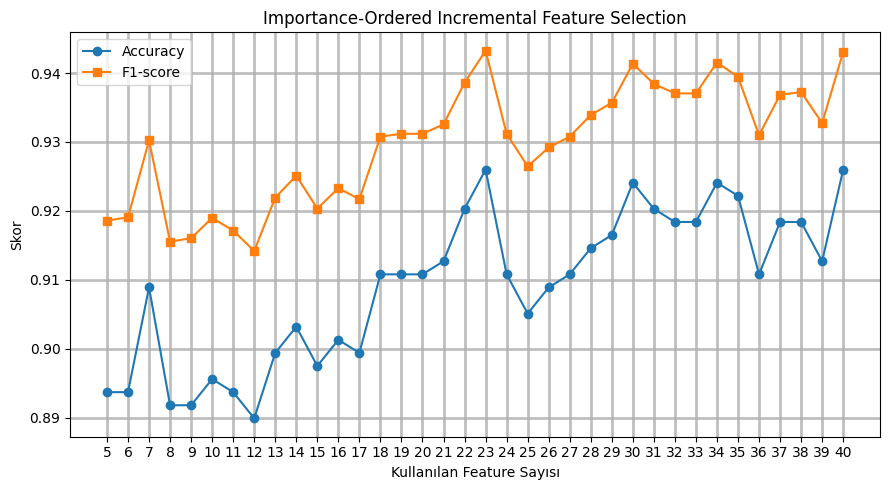

In [34]:
plt.figure(figsize=(9, 5))

plt.plot(
    results_df["num_features"],
    results_df["accuracy"],
    marker="o",
    label="Accuracy"
)

plt.plot(
    results_df["num_features"],
    results_df["f1"],
    marker="s",
    label="F1-score"
)

plt.xlabel("Kullanılan Feature Sayısı")
plt.ylabel("Skor")
plt.title("Importance-Ordered Incremental Feature Selection")

# X eksenini 1'er 1'er artır
plt.xticks(range(
    int(results_df["num_features"].min()),
    int(results_df["num_features"].max()) + 1,
    1
))

# Daha kalın grid çizgileri
plt.grid(True, which="both", linestyle="-", linewidth=2.0, alpha=0.8)

plt.legend()
plt.tight_layout()
plt.show()

# If we select only first feature the result is below, after adding second and following features train set accuracy becomes 0.99 to 1.0

In [35]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# ================================
# 1) FEATURE SAYISI (SABİT)
# ================================
best_k = 1

print("\nSEÇİLEN MODEL:")
print(f"Feature Sayısı : {best_k}")

# ================================
# 2) FEATURE SEÇİMİ
# ================================
best_features = ordered_features[:best_k]
best_indices = [feature_to_idx[f] for f in best_features]

# ================================
# 3) VERİ HAZIRLAMA
# ================================
Xtr_final = X_train[:, best_indices]
ytr_final = y_train

Xvalid_final = X_valid[:, best_indices]
Xte_final = X_test[:, best_indices]

# ================================
# 4) MODEL (RandomForest)
# ================================
final_model = Pipeline([
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

# ================================
# 5) MODEL EĞİTİMİ
# ================================
final_model.fit(Xtr_final, ytr_final)

# ================================
# 6) TAHMİNLER
# ================================
y_train_pred = final_model.predict(Xtr_final)
y_valid_pred = final_model.predict(Xvalid_final)
y_test_pred  = final_model.predict(Xte_final)

# ================================
# 7) PERFORMANS DEĞERLENDİRME
# ================================
print("\nTRAIN SET PERFORMANCE:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("F1-score:", f1_score(y_train, y_train_pred, average="binary"))

print("\nVALID SET PERFORMANCE:")
print("Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("F1-score:", f1_score(y_valid, y_valid_pred, average="binary"))

print("\nTEST SET PERFORMANCE:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("F1-score:", f1_score(y_test, y_test_pred, average="binary"))

# ================================
# 8) SEÇİLEN FEATURE'LARI YAZDIR
# ================================
print("\nSEÇİLEN 15 FEATURE:")
for i, f in enumerate(best_features, 1):
    print(f"{i:02d}. {f}")


SEÇİLEN MODEL:
Feature Sayısı : 1

TRAIN SET PERFORMANCE:
Accuracy: 0.9397508493771235
F1-score: 0.9492172584956091

VALID SET PERFORMANCE:
Accuracy: 0.6565464895635673
F1-score: 0.7193798449612402

TEST SET PERFORMANCE:
Accuracy: 0.6836283185840708
F1-score: 0.770465489566613

SEÇİLEN 15 FEATURE:
01. residual_laplacian_masked_max_area


In [36]:
best_row = results_df.loc[results_df["f1"].idxmax()]
best_k = int(best_row["num_features"])

print("\nEN İYİ MODEL:")
print(f"Feature Sayısı : {best_k}")
print(f"Accuracy       : {best_row['accuracy']:.4f}")
print(f"F1-score       : {best_row['f1']:.4f}")


EN İYİ MODEL:
Feature Sayısı : 23
Accuracy       : 0.9260
F1-score       : 0.9432


In [37]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# ================================
# 1) FEATURE SAYISI (SABİT)
# ================================

print("\nSEÇİLEN MODEL:")
print(f"Feature Sayısı : {best_k}")

# ================================
# 2) FEATURE SEÇİMİ
# ================================
best_features = ordered_features[:best_k]
best_indices = [feature_to_idx[f] for f in best_features]

# ================================
# 3) VERİ HAZIRLAMA
# ================================
Xtr_final = X_train[:, best_indices]
ytr_final = y_train

Xvalid_final = X_valid[:, best_indices]
Xte_final = X_test[:, best_indices]

# ================================
# 4) MODEL (RandomForest)
# ================================
final_model = Pipeline([
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

# ================================
# 5) MODEL EĞİTİMİ
# ================================
final_model.fit(Xtr_final, ytr_final)

# ================================
# 6) TAHMİNLER
# ================================
y_train_pred = final_model.predict(Xtr_final)
y_valid_pred = final_model.predict(Xvalid_final)
y_test_pred  = final_model.predict(Xte_final)

# ================================
# 7) PERFORMANS DEĞERLENDİRME
# ================================
print("\nTRAIN SET PERFORMANCE:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("F1-score:", f1_score(y_train, y_train_pred, average="binary"))

print("\nVALID SET PERFORMANCE:")
print("Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("F1-score:", f1_score(y_valid, y_valid_pred, average="binary"))

print("\nTEST SET PERFORMANCE:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("F1-score:", f1_score(y_test, y_test_pred, average="binary"))

# ================================
# 8) SEÇİLEN FEATURE'LARI YAZDIR
# ================================
print("\nSEÇİLEN 15 FEATURE:")
for i, f in enumerate(best_features, 1):
    print(f"{i:02d}. {f}")


SEÇİLEN MODEL:
Feature Sayısı : 23

TRAIN SET PERFORMANCE:
Accuracy: 1.0
F1-score: 1.0

VALID SET PERFORMANCE:
Accuracy: 0.9259962049335864
F1-score: 0.9432314410480349

TEST SET PERFORMANCE:
Accuracy: 0.9380530973451328
F1-score: 0.9582089552238805

SEÇİLEN 15 FEATURE:
01. residual_laplacian_masked_max_area
02. residual_laplacian_with_harmonics_masked_area_ratio
03. residual_sobel_mag_with_harmonics_masked_num_components
04. residual_laplacian_masked_mean_aspect
05. residual_laplacian_with_harmonics_mean
06. residual_laplacian_with_harmonics_masked_max_area
07. residual_laplacian_with_harmonics_std
08. fft_residual_local_output_norm_with_harmonics_std
09. fft_residual_local_output_norm_std
10. residual_sobel_mag_masked_num_components
11. residual_laplacian_with_harmonics_p95
12. residual_laplacian_mean
13. residual_sobel_mag_masked_mean_aspect
14. residual_laplacian_p95
15. residual_sobel_mag_with_harmonics_mean
16. residual_laplacian_masked_area_ratio
17. residual_sobel_mag_with_har

Train Confusion Matrix
[[1723    0]
 [   0 2692]]


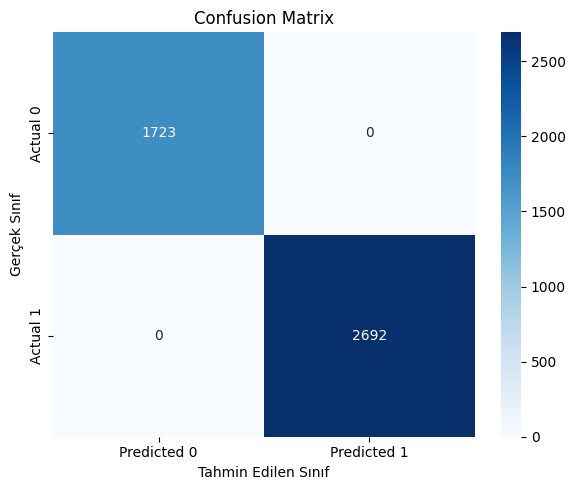

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1723
           1       1.00      1.00      1.00      2692

    accuracy                           1.00      4415
   macro avg       1.00      1.00      1.00      4415
weighted avg       1.00      1.00      1.00      4415

Validation Confusion Matrix
[[164  21]
 [ 18 324]]


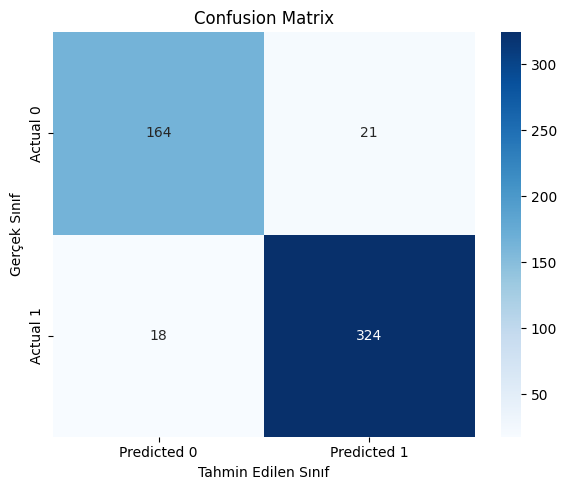

              precision    recall  f1-score   support

           0       0.90      0.89      0.89       185
           1       0.94      0.95      0.94       342

    accuracy                           0.93       527
   macro avg       0.92      0.92      0.92       527
weighted avg       0.93      0.93      0.93       527

Test Confusion Matrix
[[103  11]
 [ 17 321]]


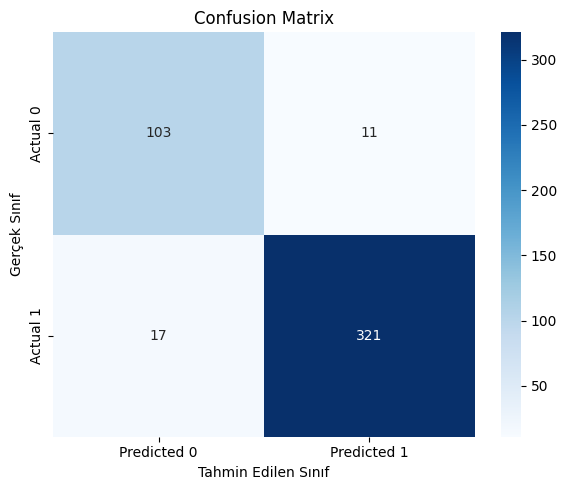

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       114
           1       0.97      0.95      0.96       338

    accuracy                           0.94       452
   macro avg       0.91      0.93      0.92       452
weighted avg       0.94      0.94      0.94       452



In [38]:
print("Train Confusion Matrix")
plot_confusion_matrix(y_train, y_train_pred)
print("Validation Confusion Matrix")
plot_confusion_matrix(y_valid, y_valid_pred)
print("Test Confusion Matrix")
plot_confusion_matrix(y_test, y_test_pred)

# 10 Fold Cross Validation

In [39]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def build_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# ===== DATA =====
X = X_train          # (n_samples, 40)
y = y_train.ravel()  # (n_samples,)

# ===== 10-FOLD CV =====
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

acc_scores = []
auc_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\nFOLD {fold}")

    X_tr, X_va = X[train_idx], X[val_idx]
    y_tr, y_va = y[train_idx], y[val_idx]

    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_va = scaler.transform(X_va)

    model = build_model(input_dim=X_tr.shape[1])

    model.fit(
        X_tr,
        y_tr,
        epochs=50,
        batch_size=32,
        verbose=0
    )

    y_va_proba = model.predict(X_va).ravel()
    y_va_pred = (y_va_proba >= 0.5).astype(int)

    acc = accuracy_score(y_va, y_va_pred)
    auc = roc_auc_score(y_va, y_va_proba)

    acc_scores.append(acc)
    auc_scores.append(auc)

    print(f"Accuracy : {acc:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")

# ===== SUMMARY =====
print("\n===== 10-FOLD CV RESULT =====")
print(f"Accuracy : {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
print(f"ROC-AUC  : {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")



FOLD 1
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Accuracy : 0.8891
ROC-AUC  : 0.9523

FOLD 2
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy : 0.8643
ROC-AUC  : 0.9369

FOLD 3
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Accuracy : 0.8959
ROC-AUC  : 0.9639

FOLD 4
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy : 0.8710
ROC-AUC  : 0.9469

FOLD 5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy : 0.8982
ROC-AUC  : 0.9589

FOLD 6


KeyboardInterrupt: 

# cross validation confusion matrix result

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Train Confusion Matrix
[[1579  144]
 [  65 2627]]


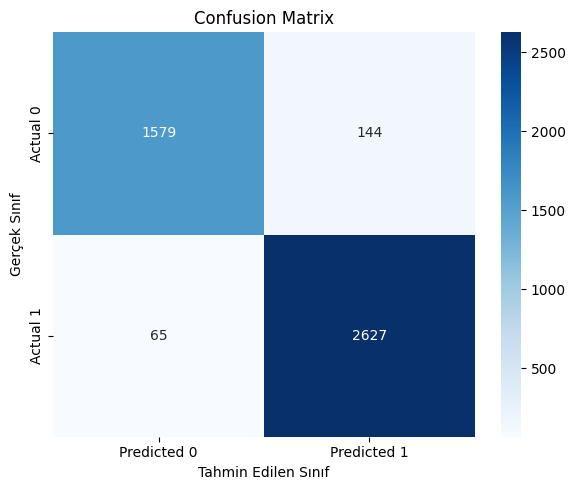

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1723
           1       0.95      0.98      0.96      2692

    accuracy                           0.95      4415
   macro avg       0.95      0.95      0.95      4415
weighted avg       0.95      0.95      0.95      4415

Validation Confusion Matrix
[[174  11]
 [ 33 309]]


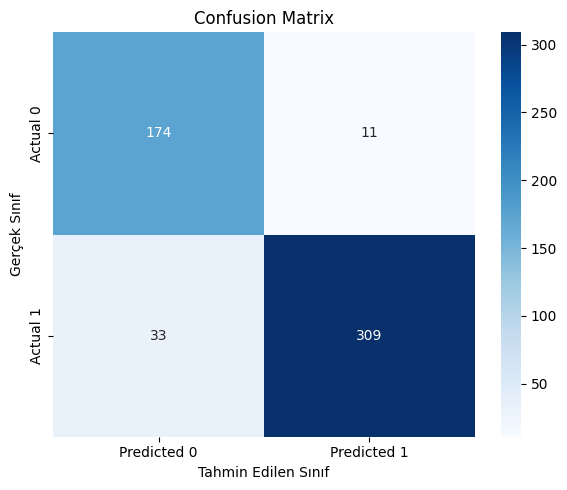

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       185
           1       0.97      0.90      0.93       342

    accuracy                           0.92       527
   macro avg       0.90      0.92      0.91       527
weighted avg       0.92      0.92      0.92       527

Test Confusion Matrix
[[104  10]
 [ 24 314]]


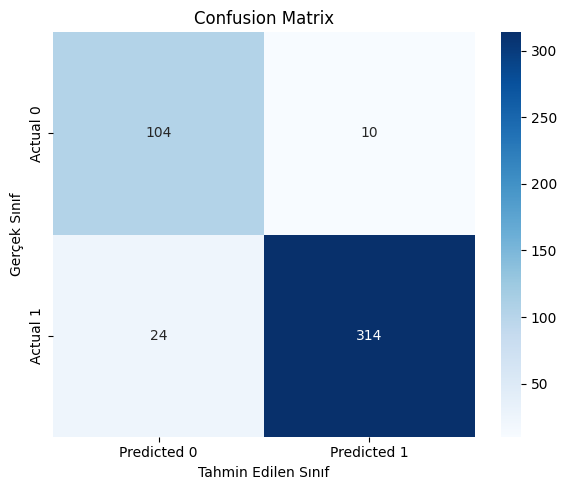

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       114
           1       0.97      0.93      0.95       338

    accuracy                           0.92       452
   macro avg       0.89      0.92      0.90       452
weighted avg       0.93      0.92      0.93       452



In [40]:
# ================================
# FINAL MODEL EĞİTİMİ
# ================================

# Scale (SADECE train ile fit)
scaler = StandardScaler()
Xtr_scaled = scaler.fit_transform(X_train)
Xvalid_scaled = scaler.transform(X_valid)
Xte_scaled = scaler.transform(X_test)

final_model = build_model(input_dim=Xtr_scaled.shape[1])

final_model.fit(
    Xtr_scaled,
    y_train.ravel(),
    epochs=50,
    batch_size=32,
    verbose=0
)

y_train_proba = final_model.predict(Xtr_scaled).ravel()
y_valid_proba = final_model.predict(Xvalid_scaled).ravel()
y_test_proba  = final_model.predict(Xte_scaled).ravel()

y_train_pred = (y_train_proba >= 0.5).astype(int)
y_valid_pred = (y_valid_proba >= 0.5).astype(int)
y_test_pred  = (y_test_proba >= 0.5).astype(int)

print("Train Confusion Matrix")
plot_confusion_matrix(y_train, y_train_pred)

print("Validation Confusion Matrix")
plot_confusion_matrix(y_valid, y_valid_pred)

print("Test Confusion Matrix")
plot_confusion_matrix(y_test, y_test_pred)

In [41]:
def plot_roc_curve(y_true, y_proba, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc_value = sk_auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(
        fpr, tpr,
        color="darkorange",
        lw=2,
        label=f"ROC curve (AUC = {roc_auc_value:.4f})"
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [42]:
y_train_proba = final_model.predict(Xtr_scaled).ravel()
y_valid_proba = final_model.predict(Xvalid_scaled).ravel()
y_test_proba  = final_model.predict(Xte_scaled).ravel()

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


# cross validation roc-auc curve result

Train ROC Curve


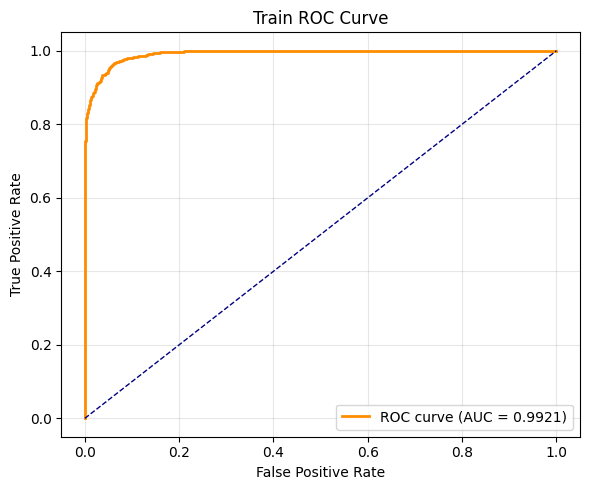

Validation ROC Curve


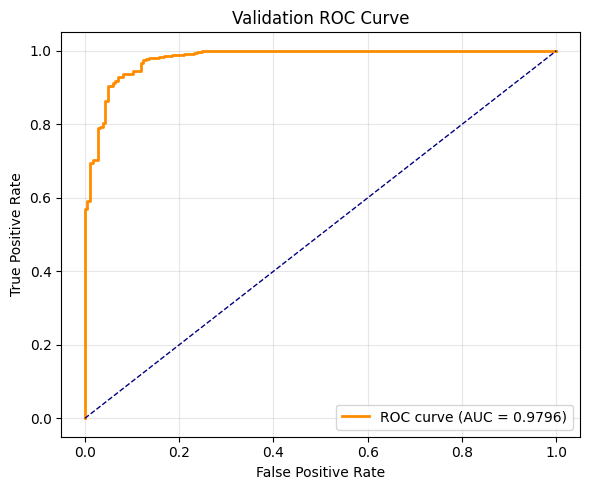

Test ROC Curve


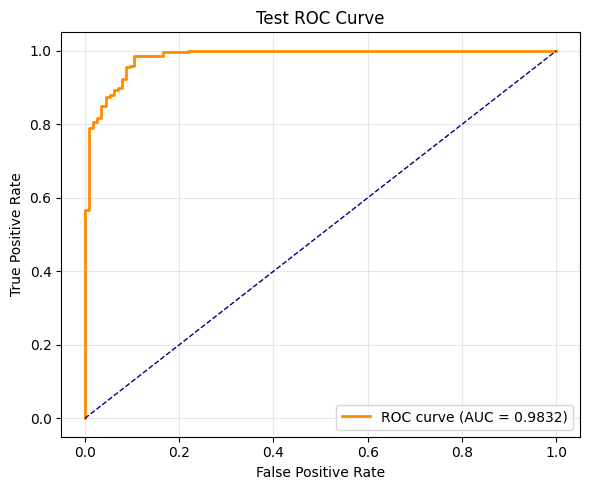

In [43]:
from sklearn.metrics import roc_curve, auc as sk_auc
print("Train ROC Curve")
plot_roc_curve(y_train, y_train_proba, title="Train ROC Curve")

print("Validation ROC Curve")
plot_roc_curve(y_valid, y_valid_proba, title="Validation ROC Curve")

print("Test ROC Curve")
plot_roc_curve(y_test, y_test_proba, title="Test ROC Curve")

# cross validation roc-auc curve result as number representation

In [44]:
from sklearn.metrics import roc_auc_score

print("\nROC-AUC SCORES:")
print("Train ROC-AUC      :", roc_auc_score(y_train, y_train_proba))
print("Validation ROC-AUC :", roc_auc_score(y_valid, y_valid_proba))
print("Test ROC-AUC       :", roc_auc_score(y_test, y_test_proba))


ROC-AUC SCORES:
Train ROC-AUC      : 0.9921176133751991
Validation ROC-AUC : 0.9796428006954323
Test ROC-AUC       : 0.9832347140039448
